# Figure 5 Master Freeze Document

This is the master document for Figure 5, which includes all code that will be frozen before receiving the final set of co-registrated cells. All frozen code is tasked to directly test a hypothesis that was made in Hebb's "The Organization of Behavior".

The methodology for all written code is provided in the *Methods* section of our paper. While the code includes the ability to test between other sets, the main sets of comparison will be coregistered cells which have assembly membership to those who have 'non-assembly' membership, or which do not participate in assemblies. Futher clarification is found in the *Methods* section. 

To analyze for probability of connections and strength of connections, we have specified these tests:

1. **Monosynaptic Pairs** - 
    1. Chi-squared test to binary connectivity
    2. Wilcoxon rank-sum test to summed Post Synaptic Density (PSD)
2. **Per-cell Outbound and Inbound**
    1. Wilcoxon rank-sum test to probability of connection
3. **Per-cell Nonzero Outbound and Inbound**
    1. Wilcoxon signed rank test to summed PSD volumes
    2. Wilcoxon rank-sum to summed PSD volumes
4. **Centrality Measurements**
    1. Wilcoxon rank-sum to Out-Degree Centrality
    2. Wilcoxon rank-sum to In-Degree Centrality
    3. Wilcoxon rank-sum to Betweenness Centrality
    4. Wilcoxon rank-sum to Closeness Centrality
5. Repeat 1-3 for **Multisynaptic (3-Neuron) Chains**
6. Repeat 1-3 for **Multisynaptic Chains with a middle interneuron**

We additionally perform a **Tail Analysis**, where we perform a **Chi-Squared Test of Goodness-of-Fit** for differences in proportion of connection type comparing all to "tail" connections. 

Any other analysis that will be explored later are presented in the other Figure 5 Master document.

In [93]:
# importing packages
import matplotlib.pyplot as plt
import ptitprince as pt
import random
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import networkx as nx
import pickle
import itertools
from dotmotif import Motif, GrandIsoExecutor
from scipy.stats import kruskal, f_oneway, levene, ranksums, ttest_ind, wilcoxon, norm, chi2_contingency, chisquare
from statsmodels.stats.multitest import multipletests
from sklearn import mixture
from scipy.interpolate import interp1d
from tabulate import tabulate
from statannotations.Annotator import Annotator

plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (10,10)
sns.set_theme(style="whitegrid")
random.seed(747)

# Import Stefan's Library for Data Management of V1DD
from lsmm_data import LSMMData

In [94]:
# Set-Wise Comparison Functions: Determining the intersection of assembly assignment of two pyramidal cells 
# These comparison functions map to C in the statistical methods section.

def assembly(pre, post, A):
    return (pre not in no_A) and (post not in no_A)
    
def assembly(pre, post, A):
    try:
        return not A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def disjoint(pre, post, A):
    try:
        return A[pre].isdisjoint(A[post])
    except KeyError:
        return False

def nonassembly(pre, post, A):
    return (pre in no_A) and (post in no_A) # type: ignore

def no_a_a(pre, post, A):
    return (pre in no_A) and (post not in no_A) # type: ignore

def a_no_a(pre, post, A):
    return (pre not in no_A) and (post in no_A) # type: ignore

def no_a_to_any(pre, _, A):
    return (pre in no_A) # type: ignore

def a_to_any(pre, _, A):
    return (pre not in no_A) # type: ignore

comparison_functions = [assembly, nonassembly, no_a_a, a_no_a, no_a_to_any, a_to_any]
groups = ['assembly', 'nonassembly']

## Monosynaptic Analysis on Pyramidal Cell Rectangular Connectome

In [95]:
def save_figure(figure_name):
    plt.savefig(
        f"./draft_figures/{figure_name}.png",
        dpi=500,
        bbox_inches="tight")
    
def plot_assembly_vs_nonassembly(assembly_values, nonassembly_values, title, y_lab, p_val, save=False, figure_name=None):
    """
    Plots a raincloud plot for two connection type groups, with sample sizes in the y-axis labels.

    Parameters:
        assembly_values (list or array): Data for assembly assembly group.
        nonassembly_values (list or array): Data for nonassembly assembly group.
        title (str): Title of the plot.
        y_lab (str): Label for the x-axis.
        p_val (float): P-value for significance annotation.
        save_fig (bool): Whether to save the figure.
        folder (str): Folder to save the figure if save_fig is True.
    """
    # Calculate sample sizes
    n_assembly = len(assembly_values)
    n_nonassembly = len(nonassembly_values)

    y_labels = [f"Assembly\n(n={n_assembly})", f"Non-assembly\n(n={n_nonassembly})"]

    # Data frame for easier plotting
    data = pd.DataFrame({
        "Values": np.concatenate([assembly_values, nonassembly_values]),
        "Group": [y_labels[0]] * n_assembly + [y_labels[1]] * n_nonassembly
    })

    # Set up the plot
    plt.figure(figsize=(12, 10))
    sns.set_theme(style="whitegrid")

    # Create the raincloud plot
    ax = pt.RainCloud(
        y="Values",
        x="Group",
        data=data,  
        palette=[(.4, .6, .8, .5), 'grey'],
        width_viol=0.3,  
        alpha=0.8,  
        move=0.25,
        point_size = 6,  
        orient="v" 
    )

    # Set markings for significance
    pairs = [(y_labels[0], y_labels[1])]
    annot = Annotator(ax, 
                    pairs,
                    data=data,
                    x="Group",
                    y="Values",
                    order=y_labels # Force the order
                    )
    annot.set_pvalues([p_val])
    annot.configure(text_format="star", loc="inside", fontsize=30)
    annot.annotate()

    # Add plot title and labels
    plt.title(title, size=30)
    plt.xlabel("Connection Type", size=24)
    plt.ylabel(y_lab, size=24)
    plt.xticks(fontsize = 22)
    plt.yticks(fontsize = 22)

    if save == True:
        save_figure(figure_name)

    plt.tight_layout()
    plt.show()
    plt.close()

def plot_assembly_vs_nonassembly_with_side_plot(assembly_values, nonassembly_values, title, 
                                           y_lab, p_val, save=False, figure_name=None
):
    """
    Plots a raincloud plot comparing connection types, 
    plus a smaller side subplot summarizing mean ± SEM for each group.

    Parameters:
        assembly_values (list or array): Data for assembly assembly group.
        nonassembly_values (list or array): Data for nonassembly assembly group.
        title (str): Title of the plot.
        y_lab (str): Label for the x-axis.
        p_val (float): P-value for significance annotation.
        save_fig (bool): Whether to save the figure.
        folder (str): Folder to save the figure if save_fig is True.
    """

    # Calculate sample sizes
    n_assembly = len(assembly_values)
    n_nonassembly = len(nonassembly_values)

    y_labels = [f"Assembly\n(n={n_assembly})", f"Non-assembly\n(n={n_nonassembly})"]

    # Build a frame for easier plotting
    data = pd.DataFrame({
        "Values": np.concatenate([assembly_values, nonassembly_values]),
        "Group": [y_labels[0]] * n_assembly + [y_labels[1]] * n_nonassembly
    })

    # Compute the statistics for the side plot
    # (Assuming values > 0 for simplicity; modify if needed.)
    assembly_log = np.log10(assembly_values)
    nonassembly_log = np.log10(nonassembly_values)

    mean_assembly_log = np.mean(assembly_log)
    mean_nonassembly_log = np.mean(nonassembly_log)
    sem_assembly_log = stats.sem(assembly_log, ddof=1) if n_assembly > 1 else 0
    sem_nonassembly_log = stats.sem(nonassembly_log, ddof=1) if n_nonassembly > 1 else 0

    # Set up a figure with two subplots
    fig = plt.figure(figsize=(15, 10))
    # Allocate 2 columns with a narrower column on the right
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[3, 1], wspace=0.3)
    
    # Set up styling
    ax_main = fig.add_subplot(gs[0])
    ax_side = fig.add_subplot(gs[1])
    sns.set_theme(style="whitegrid")

    # --- Main plot (original RainCloud) ---
    pt.RainCloud(
        y="Values",
        x="Group",
        data=data,
        palette=[(.4, .6, .8, .5), 'grey'],
        width_viol=0.3,
        alpha=0.8,
        move=0.25,
        point_size=6,
        orient="v",
        ax=ax_main
    )

    # Annotate significance
    pairs = [(y_labels[0], y_labels[1])]
    annot = Annotator(ax_main, 
                      pairs,
                      data=data,
                      x="Group",
                      y="Values",
                      order=y_labels # Force the order
                      )
    annot.set_pvalues([p_val])
    annot.configure(text_format="star", loc="inside", fontsize=28)
    annot.annotate()

    # Axis title and labels
    ax_main.set_title(title, size=24)
    ax_main.set_xlabel("Connection Type", size=20)
    ax_main.set_ylabel(y_lab, size=20)
    ax_main.tick_params(labelsize=20)

    # --- Side plot (Mean ± SEM of log(data))---
    # Currently place two horizontal lines and use fill_between for each ± sem region.

    x_vals = [1, 2]  # x positions for assembly and nonassembly
    mean_logs = [mean_assembly_log, mean_nonassembly_log]
    sem_logs = [sem_assembly_log, sem_nonassembly_log]
    colors = [(0.4, 0.6, 0.8, 0.8), 'grey']

    for i, x in enumerate(x_vals):
        m_log = mean_logs[i]
        s_log = sem_logs[i]
        c = colors[i]

        # Horizontal line for mean
        ax_side.hlines(
            y = m_log, 
            xmin = x - 0.15, 
            xmax = x + 0.15, 
            color = c, 
            linewidth = 3
        )
        # Shaded area for ± SEM
        ax_side.fill_betweenx(
            y = [m_log - s_log, m_log + s_log],
            x1 = x - 0.15,
            x2 = x + 0.15,
            color = c,
            alpha = 0.4
        )

    # Tidy up side axis
    ax_side.set_title("Mean ± SEM (log-transformed)", size=20)
    ax_side.set_xlim(0.5, 2.5)  
    ax_side.set_xticks(x_vals)
    ax_side.set_xticklabels(["Assembly", "Non-\nassembly"], fontsize=16)
    ax_side.tick_params(axis='y', labelsize=16)
    # Show that y-values are on a log base 10 scale
    ax_side.set_ylabel(r"$\log_{10}(\mathrm{\mu m^3})$", size=20)

    if save and figure_name is not None:
        save_figure(figure_name)

    plt.tight_layout()
    plt.show()
    plt.close()

def chi_squared_analysis(data, save=False, figure_name=None):
    """
    Perform an overall chi-squared test of independence on a contingency table and display
    observed and expected values as pretty tables with test results.

    Parameters:
    data (pd.DataFrame): A DataFrame representing the contingency table.

    Returns:
    None: Prints the tables and results directly.
    """
    # Perform chi-squared test
    chi2, p, dof, expected = chi2_contingency(data)
    expected_df = pd.DataFrame(expected, index=data.index, columns=data.columns)

    # Create pretty tables
    observed_table = tabulate(
        [[row] + list(data.loc[row]) for row in data.index],
        headers=["Connection Type"] + list(data.columns),
        tablefmt="pretty"
    )
    expected_table = tabulate(
        [[row] + [f"{val:.2f}" for val in expected_df.loc[row]] for row in expected_df.index],
        headers=["Connection Type"] + list(expected_df.columns),
        tablefmt="pretty"
    )

    # Print the results
    print("Observed Contingency Table:")
    print(observed_table, "\n")
    print("Expected Contingency Table:")
    print(expected_table, "\n")
    print("Chi-squared Test Results:")
    print(f"Chi-squared Statistic: {chi2:.2f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-value: {p:.4g}")

    # Plot the heatmap with updated annotation and tick font sizes
    plt.figure(figsize=(6, 3))
    sns.set_theme(style="whitegrid")

    # Create a custom uniform heatmap
    ax = sns.heatmap(
        data,
        annot=True,               # Add annotations for the counts
        fmt="d",                  # Integer format for annotations
        cmap=sns.color_palette(["lightgrey"], as_cmap=True),  # All cells the same light gray color
        cbar=False,               # Remove the color bar
        annot_kws={"fontsize": 22},  # Set font size for annotations
        linewidths=2,             # Add grid lines
        linecolor='black'         # Grid line color
    )

    # Add title and labels
    plt.title(f"Probability of Connection\nChi-squared P-value: {p:.4g}", size=24)
    plt.xlabel("Connection Status", size=22)
    plt.ylabel("Connection Type", size=22)
    plt.xticks(fontsize=22)
    ax.set_yticklabels(data.index, rotation=90, va='center', fontsize=22)

    if save==True:
        save_figure(figure_name)

    plt.tight_layout()
    plt.show()

def chi_squared_analysis_v2(data, save=False, figure_name=None):
    """
    Perform an overall chi-squared test of independence on a contingency table and display
    observed and expected values as pretty tables with test results. This version plots a 
    heatmap of the *cell-wise chi-square contributions* (rather than the raw counts), 
    to visualize which cells contribute most to the chi-square statistic.

    Parameters:
    data (pd.DataFrame): A DataFrame representing the contingency table constructed from the
                         `construct_contingency_table` function.
    save (bool): Whether to save the resulting plot.
    figure_name (str or None): The filename to use if saving the plot.

    Returns:
    None: Prints the tables and results directly.
    """
    # Perform chi-squared test
    chi2, p, dof, expected = chi2_contingency(data)
    expected_df = pd.DataFrame(expected, index=data.index, columns=data.columns)

    # Create pretty tables
    observed_table = tabulate(
        [[row] + list(data.loc[row]) for row in data.index],
        headers=["Connection Type"] + list(data.columns),
        tablefmt="pretty"
    )
    expected_table = tabulate(
        [[row] + [f"{val:.2f}" for val in expected_df.loc[row]] for row in expected_df.index],
        headers=["Connection Type"] + list(expected_df.columns),
        tablefmt="pretty"
    )

    # Print the results
    print("Observed Contingency Table:")
    print(observed_table, "\n")
    print("Expected Contingency Table:")
    print(expected_table, "\n")
    print("Chi-squared Test Results:")
    print(f"Chi-squared Statistic: {chi2:.2f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-value: {p:.4g}")

    # Calculate the cell-wise contributions
    contributions = (data - expected_df) ** 2 / expected_df
    print("Cell-wise Chi-Square Contributions:")
    # contributions = contributions.fillna(0)  # Replace NaN with 0 for cells with no expected count
    print(contributions)

    data_array = np.zeros((2, 2))
    data_array[0, 0] = contributions.loc["Assembly", "Connected"]
    data_array[0, 1] = contributions.loc["Assembly", "Not Connected"]
    data_array[1, 0] = contributions.loc["Nonassembly", "Connected"]
    data_array[1, 1] = contributions.loc["Nonassembly", "Not Connected"]

    print(data_array)
    print(data_array.shape)

    # Plot the heatmap with updated annotation and tick font sizes
    plt.figure(figsize=(8, 4))
    # sns.set_theme(style="whitegrid")

    

    # Create a custom uniform heatmap
    ax = sns.heatmap(
        data_array,
        annot=True,               # Add annotations for the counts
        fmt=".4f",                  # Integer format for annotations
        cmap=sns.color_palette(["lightgrey"], as_cmap=True),  # All cells the same light gray color
        cbar=False,               # Remove the color bar
        annot_kws={"fontsize": 22},  # Set font size for annotations
        linewidths=1,             # Add grid lines
        linecolor='black'         # Grid line color
    )

    # Add title and labels
    plt.title(f"Cell-wise Chi-Square Contributions\nP-value: {p:.4g}",size=24)
    plt.xlabel("Connection Status", size=22)
    plt.ylabel("Connection Type", size=22)
    plt.xticks(fontsize=22)
    ax.set_yticklabels(data.index, rotation=90, va='center', fontsize=22)


    if save==True:
        save_figure(figure_name)

    plt.tight_layout()
    plt.show()

def construct_contingency_table(data_dict, groups):
    # Generate lists for connected and not connected counts
    connected_counts = [sum(1 for _, val in data_dict[group].items() if val == 1) for group in groups]
    not_connected_counts = [sum(1 for _, val in data_dict[group].items() if val == 0) for group in groups]
    
    # Create the DataFrame
    return pd.DataFrame({
        'Connected': connected_counts,
        'Not Connected': not_connected_counts
    }, index=[group.capitalize() for group in groups])

def ranksum_signedrank_two_group_comparison(comparison_dict, aggregation_method="by connection", directionality=None, data_type="binary", 
                            paired=False, non_zero=False, chain_test = False, chain_description = "Excitatory", save=True, figure_name=None):
    """
    Compares 'assembly' and 'nonassembly' groups based on connection type and data type.
    Uses a one-sided Wilcoxon rank-sum test and performs a Wilcoxon signed-rank test if paired=True.

    Parameters:
    - comparison_dict (dict): Dictionary with 'assembly' and 'nonassembly' data.
    - aggregation_method (str): Type of connection ('connection' for pairwise, 'cell' for inbound/outbound by cell).
    - directionality (str): Direction of connectivity for 'cell' type ('inbound' or 'outbound').
    - data_type (str): Data type ('binary' for connectivity, 'summed_psd' for nonzero PSD).
    - paired (bool): If True, performs an additional Wilcoxon signed-rank test on paired data.
    - non_zero (bool): If True, filters out zero entries for summed PSD.
    - chain_test (bool): If True, the test is considering chains.
    - chain_description (str): Type of intermediate cell in chain ('excitatory' or 'inhibitory')
    """

    # Set title and labels based on connection_type and data_type
    if aggregation_method == "connection":  # Pairwise connections
        if data_type == "binary":
            title = "Binary Connectivity"
            y_lab = "Binary Connections"
            folder = "pairwise_binary_connectivity"
        elif data_type == "summed_psd":
            if non_zero == True:
                title = "Nonzero Summed PSD"
                y_lab = "Nonzero Summed PSD (\u03bcm$^3$)"
                folder = "pairwise_nonzero_summed_psd"
            else:
                title = "Summed PSD"
                y_lab = "Summed PSD (\u03bcm$^3$)"
                folder = "pairwise_summed_psd"
        else:
            raise ValueError("Invalid data_type for pairwise connection.")

    elif aggregation_method == "cell":  # By cell with inbound/outbound directionality
        if directionality not in ["inbound", "outbound"]:
            raise ValueError("For 'cell' connection_type, directionality must be 'inbound' or 'outbound'.")
        
        if data_type == "binary":
            title = f"Probability of {directionality.capitalize()} Connection by Cell"
            y_lab = f"Probability of {directionality.capitalize()} Connection"
            folder = f"{directionality}_connection_probability"
        elif data_type == "summed_psd":
            title = f"Average Nonzero {directionality.capitalize()} PSD by Cell"
            y_lab = f"Average Nonzero {directionality.capitalize()} PSD (\u03bcm$^3$)"
            folder = f"{directionality}_average_nonzero_psd"
        else:
            raise ValueError("Invalid data_type for inbound/outbound connection.")
    else:
        raise ValueError("Invalid connection_type. Must be 'connection' or 'cell'.")

    if chain_test:
        title += f" ({chain_description} Chains)"
        y_lab = y_lab.replace("PSD", "Chain PSD Products")
        
    assembly_values = np.array(list(comparison_dict["assembly"].values()))
    nonassembly_values = np.array(list(comparison_dict["nonassembly"].values()))
    # Filter out zeros if non_zero is specified for summed_psd
    if non_zero and data_type == "summed_psd":
        assembly_values = assembly_values[assembly_values != 0]
        nonassembly_values = nonassembly_values[nonassembly_values != 0]

    # Perform the Wilcoxon rank-sum test (one-sided, assembly > nonassembly)
    if chain_description=='Inhibitory':
        rank_sum_stat, rank_sum_p = stats.ranksums(assembly_values, nonassembly_values, alternative='less')
        print(f"Wilcoxon Rank-Sum Test (unpaired, assembly < nonassembly):\nStatistic: {rank_sum_stat:.4g}, P-value: {rank_sum_p:.4g}")
    else:
        rank_sum_stat, rank_sum_p = stats.ranksums(assembly_values, nonassembly_values, alternative='greater')
        print(f"Wilcoxon Rank-Sum Test (unpaired, assembly > nonassembly):\nStatistic: {rank_sum_stat:.4g}, P-value: {rank_sum_p:.4g}")

    title = f'{title}\nRank-Sum P-value: {rank_sum_p:.4g}'

    # If paired=True, also perform a Wilcoxon signed-rank test on paired observations
    if paired:
        assembly_keys = set(comparison_dict.get('assembly', {}).keys())
        nonassembly_keys = set(comparison_dict.get('nonassembly', {}).keys())
        common_keys = assembly_keys & nonassembly_keys

        if common_keys:
            # Extract paired data for common keys
            assembly_paired = np.array([comparison_dict["assembly"][key] for key in common_keys])
            nonassembly_paired = np.array([comparison_dict["non-assembly"][key] for key in common_keys])

            # Perform Wilcoxon signed-rank test on paired data
            if chain_description=='Inhibitory':
                signed_rank_stat, signed_rank_p = stats.wilcoxon(assembly_paired, nonassembly_paired, alternative='less')
                print(f"Wilcoxon Signed-Rank Test (paired, assembly < nonassembly):\nStatistic: {signed_rank_stat:.4g}, P-value: {signed_rank_p:.4g}")
            else:
                signed_rank_stat, signed_rank_p = stats.wilcoxon(assembly_paired, nonassembly_paired, alternative='greater')
                print(f"Wilcoxon Signed-Rank Test (paired, assembly > nonassembly):\nStatistic: {signed_rank_stat:.4g}, P-value: {signed_rank_p:.4g}")

            title = f'{title}, Signed-Rank P-value: {signed_rank_p:.4g}'
        else:
            print("No common observations found for paired analysis.")

    plot_assembly_vs_nonassembly(assembly_values, nonassembly_values, title, y_lab, p_val = rank_sum_p, save=True, figure_name=figure_name)
    plot_assembly_vs_nonassembly_with_side_plot(assembly_values, nonassembly_values, title, y_lab, p_val = rank_sum_p, save=True, figure_name=figure_name + "_with_side_plot")

### Prepare Sets

In [96]:
with open('pyr_cells_rectangular_connectome.json') as f:
    lsmm_json_input = json.load(f)
v1dd_data = LSMMData.LSMMData(lsmm_json_input)

data_a = v1dd_data.data
params_a = v1dd_data.params
dirs_a = v1dd_data.dirs
mappings_a = v1dd_data.mappings

Filtering to pyramidal cells only
459


/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/lsmm_data/LSMMData.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['connectome_index'] = data['structural']['post_cell'].index
/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/lsmm_data/LSMMData.py:417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['structural']['post_cell']['pt_position'] = [[data['structural']['post_cell'].iloc[i]['pt_position_x'],data['structur

Generating Connectome...


100%|██████████| 44293/44293 [00:11<00:00, 3730.89it/s]


Generating Connectome...


100%|██████████| 44293/44293 [00:14<00:00, 3144.15it/s]


In [97]:
### Pull necessary data from V1DD using LSMMData Manager
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index
synapse_table = data_a['structural']['synapse']

# Establish seperate sets for the pre and post synaptic partnes
# This is necessary as the set of connectome index of pre-synaptic cells do not 
# match the post-synaptic cells due to allowing unproofread post-synaptic targets.
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()

no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']

pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))
# Each cell has a distinct root id, so it is unnecessary to establish different sets
assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df['size'] = synapses_df['size'] * (9 * 9 * 45) / (10**9) # Voxels -> Cubic micrometers

# Filter cell tables to only assembly cells
cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

# Finalized set of Root IDs, which are 
pre_root_ids = set(cell_table['pt_root_id'].values)
post_root_ids = set(post_cell_table['pt_root_id'].values)
all_root_ids = pre_root_ids | post_root_ids

In [98]:
### Prep the sets for Analysis, following our description in the Methods section
# Collect our connectomes of pre and post synaptic sets based on the root_ids of the neurons
w = {}
s = {}
b = {}
for pre in pre_root_ids:
    for post in post_root_ids:
        if pre != post:
            w[(pre, post)] = 0
            s[(pre, post)] = 0
            b[(pre, post)] = 0

for i, row in synapses_df.iterrows():
    pre = row['pre_pt_root_id']
    post = row['post_pt_root_id']
    w[(pre, post)] += row['size']
    s[(pre, post)] += 1
    b[(pre, post)] = 1

# Split out assemblies and no_a
assembly_names = set(assembly_to_root_ids.keys()) - set(['No A'])
A_invert = {assembly: set(assembly_to_root_ids[assembly]) for assembly in assembly_names}
no_A = set(assembly_to_root_ids['No A'])
all_coregistered_root_ids = mappings_a['assemblies_by_pt_root_id'].keys()
assembly_root_ids_excluding_no_A = set(all_coregistered_root_ids) - no_A
A = {pt_root_id: set(mappings_a['assemblies_by_pt_root_id'][pt_root_id]) for pt_root_id in all_root_ids if 'No A' not in mappings_a['assemblies_by_pt_root_id'][pt_root_id]}

In [99]:
W_nonzero_pairwise = {}
B_pairwise = {}
for connection_type in comparison_functions:
    W_nonzero_pairwise[connection_type.__name__] = {}
    B_pairwise[connection_type.__name__] = {}
    for (j, i) in w.keys():
        if connection_type(j, i, A):
            B_pairwise[connection_type.__name__][(j, i)] = 1 if w[(j, i)] > 0 else 0
            if w[(j, i)] > 0:
                W_nonzero_pairwise[connection_type.__name__][(j, i)] = w[(j, i)]

W_nonzero_out = {}
for connection_type in comparison_functions:
    W_nonzero_out[connection_type.__name__] = {}
    for j in pre_root_ids:
        if len([i for i in post_root_ids if i != j and connection_type(j, i, A) and w[(j, i)] > 0]) > 0:
            W_nonzero_out[connection_type.__name__][j] = sum([w[(j, i)] for i in post_root_ids if connection_type(j, i, A) and j != i]) / len([i for i in post_root_ids if i != j and connection_type(j, i, A) and w[(j, i)] > 0])

W_nonzero_in = {}
for connection_type in comparison_functions:
    W_nonzero_in[connection_type.__name__] = {}
    for i in post_root_ids:
        if len([j for j in pre_root_ids if connection_type(j, i, A)]) > 0 and len([j for j in pre_root_ids if j != i and connection_type(j, i, A) and w[(j,i)] > 0]):
            W_nonzero_in[connection_type.__name__][i] = sum([w[(j, i)] for j in pre_root_ids if connection_type(j, i, A) and i != j]) / len([j for j in pre_root_ids if j != i and connection_type(j, i, A) and w[(j,i)] > 0])

B_out = {}
for connection_type in comparison_functions:
    B_out[connection_type.__name__] = {}
    for j in pre_root_ids:
        if len([i for i in post_root_ids if connection_type(j, i, A) and j != i]) > 0:
            B_out[connection_type.__name__][j] = sum([b[(j, i)] for i in post_root_ids if connection_type(j, i, A) and j != i]) / len([i for i in post_root_ids if connection_type(j, i, A) and j != i])

B_in = {}
for connection_type in comparison_functions:
    B_in[connection_type.__name__] = {}
    for i in post_root_ids:
        if len([j for j in pre_root_ids if connection_type(j, i, A) and i != j]) > 0:
            B_in[connection_type.__name__][i] = sum([b[(j, i)] for j in pre_root_ids if connection_type(j, i, A) and i != j]) / len([j for j in pre_root_ids if connection_type(j, i, A) and j != i])
# create contingency table for monosynaptic connections count by connection type
monosynaptic_pairwise_contingency_table = construct_contingency_table(B_pairwise, groups)

In [100]:
# Save all produced sets
save_folder = 'master_freeze_produced_sets/monosynaptic_rectangular/rectangular_'
with open(f"{save_folder}W_nonzero_pairwise.pkl", "wb") as f:
    pickle.dump(W_nonzero_pairwise, f)
with open(f"{save_folder}W_nonzero_out.pkl", "wb") as f:
    pickle.dump(W_nonzero_out, f)
with open(f"{save_folder}W_nonzero_in.pkl", "wb") as f:
    pickle.dump(W_nonzero_in, f)
with open(f"{save_folder}B_out.pkl", "wb") as f:
    pickle.dump(W_nonzero_out, f)
with open(f"{save_folder}B_in.pkl", "wb") as f:
    pickle.dump(W_nonzero_in, f)

### Report Results

Monosynaptic Pairwise Connections by Connection Type Contingency Table:
Observed Contingency Table:
+-----------------+-----------+---------------+
| Connection Type | Connected | Not Connected |
+-----------------+-----------+---------------+
|    Assembly     |    107    |     4838      |
|   Nonassembly   |    24     |     1743      |
+-----------------+-----------+---------------+ 

Expected Contingency Table:
+-----------------+-----------+---------------+
| Connection Type | Connected | Not Connected |
+-----------------+-----------+---------------+
|    Assembly     |   96.51   |    4848.49    |
|   Nonassembly   |   34.49   |    1732.51    |
+-----------------+-----------+---------------+ 

Chi-squared Test Results:
Chi-squared Statistic: 4.00
Degrees of Freedom: 1
P-value: 0.0454


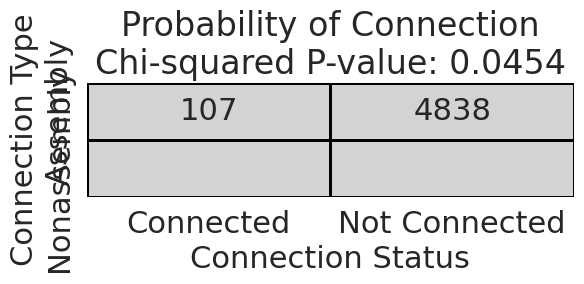

Observed Contingency Table:
+-----------------+-----------+---------------+
| Connection Type | Connected | Not Connected |
+-----------------+-----------+---------------+
|    Assembly     |    107    |     4838      |
|   Nonassembly   |    24     |     1743      |
+-----------------+-----------+---------------+ 

Expected Contingency Table:
+-----------------+-----------+---------------+
| Connection Type | Connected | Not Connected |
+-----------------+-----------+---------------+
|    Assembly     |   96.51   |    4848.49    |
|   Nonassembly   |   34.49   |    1732.51    |
+-----------------+-----------+---------------+ 

Chi-squared Test Results:
Chi-squared Statistic: 4.00
Degrees of Freedom: 1
P-value: 0.0454
Cell-wise Chi-Square Contributions:
             Connected  Not Connected
Assembly      1.139515       0.022683
Nonassembly   3.188965       0.063479
[[1.13951501 0.02268295]
 [3.18896533 0.06347887]]
(2, 2)


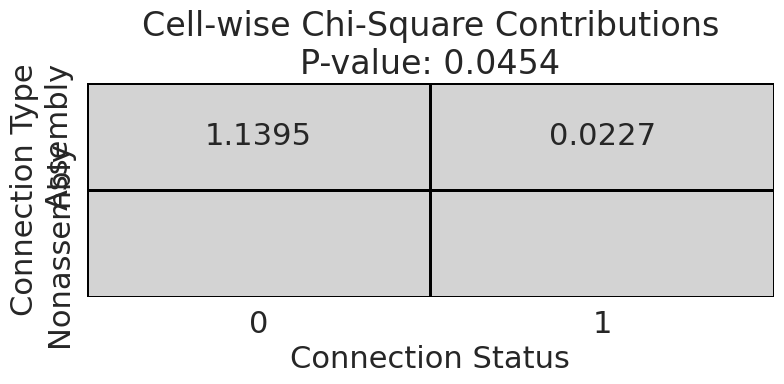

In [101]:
print("Monosynaptic Pairwise Connections by Connection Type Contingency Table:")
chi_squared_analysis(monosynaptic_pairwise_contingency_table, save=True, figure_name='Prob_Conn_by_Conn_Type')
chi_squared_analysis_v2(monosynaptic_pairwise_contingency_table, save=True, figure_name='Prob_Conn_by_Conn_Type_v2')

Wilcoxon Rank-Sum Test (unpaired, assembly > nonassembly):
Statistic: -0.8211, P-value: 0.7942
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=107) vs. Non-assembly
(n=24): Custom statistical test, P_val:7.942e-01


/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


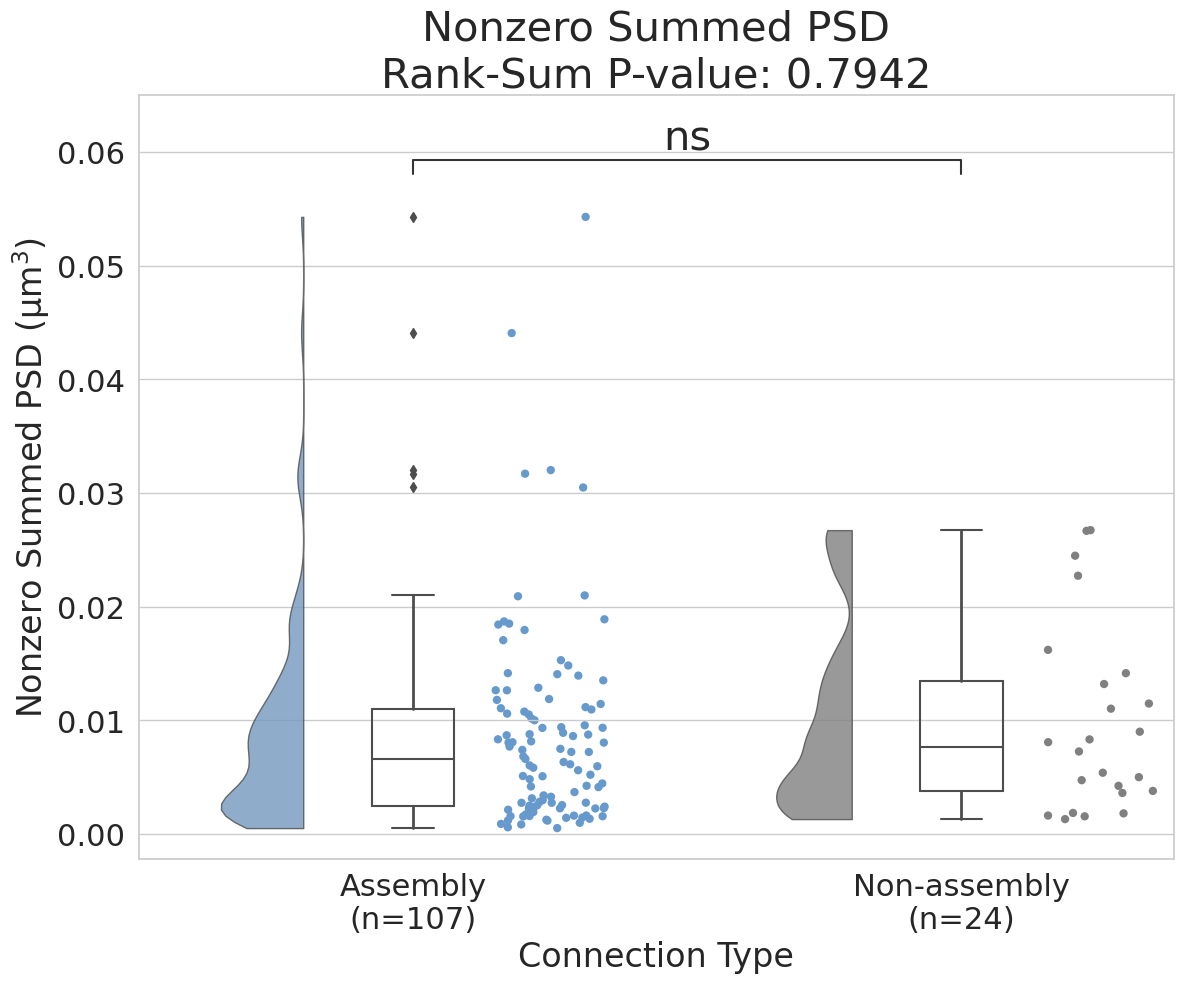

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=107) vs. Non-assembly
(n=24): Custom statistical test, P_val:7.942e-01


/tmp/ipykernel_2611/1861814550.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


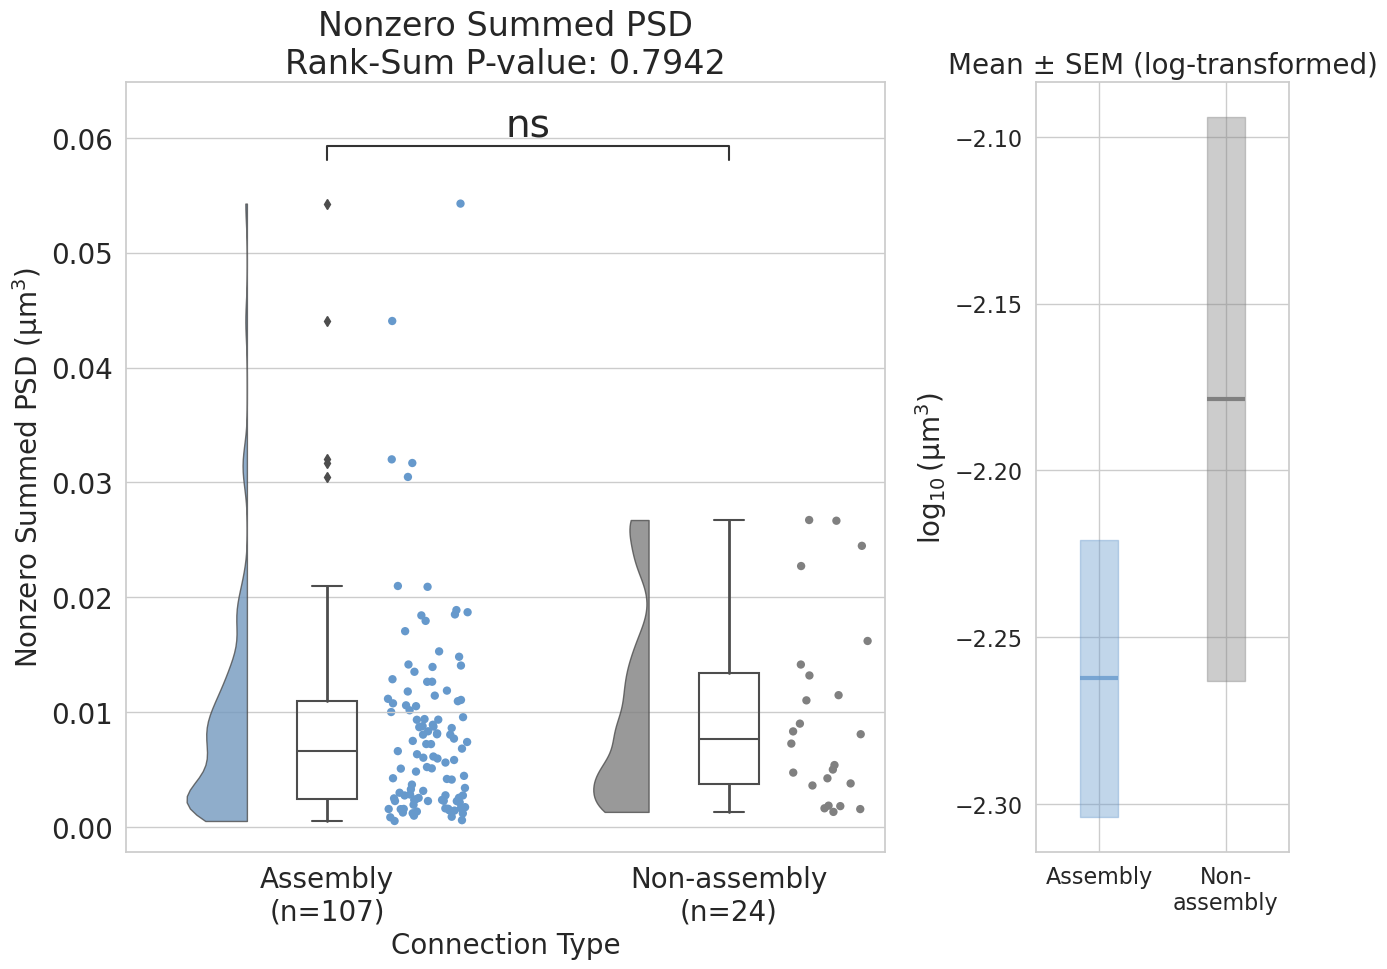

In [102]:
ranksum_signedrank_two_group_comparison(W_nonzero_pairwise,
                                        aggregation_method='connection',
                                        data_type='summed_psd',
                                        non_zero=True,
                                        save=True,
                                        figure_name='Nonzero_PSD_by_Conn'
                                        )

Wilcoxon Rank-Sum Test (unpaired, assembly > nonassembly):
Statistic: -0.08479, P-value: 0.5338
No common observations found for paired analysis.
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-assembly
(n=19): Custom statistical test, P_val:5.338e-01


/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


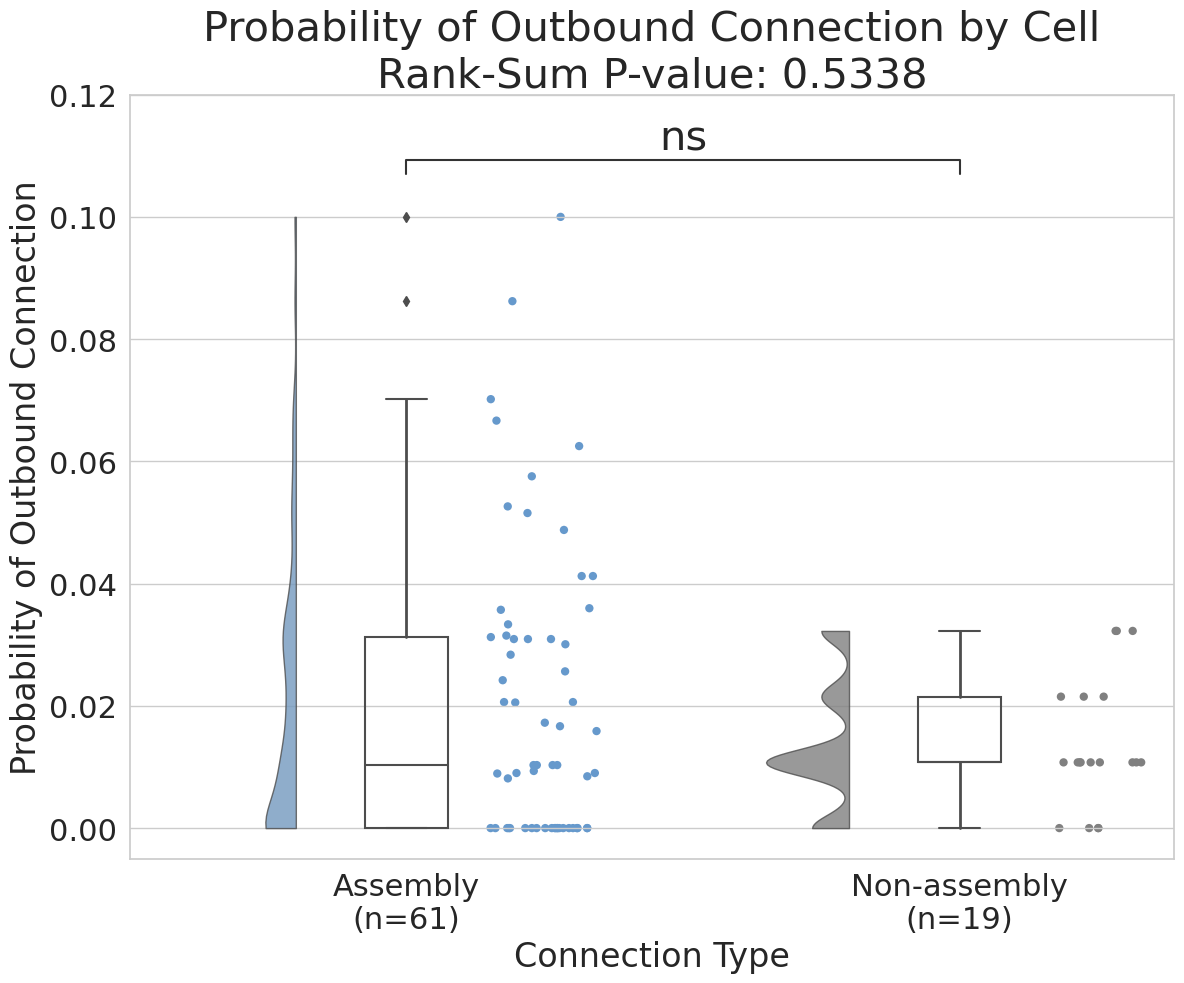

/tmp/ipykernel_2611/1861814550.py:107: RuntimeWarning: divide by zero encountered in log10
  assembly_log = np.log10(assembly_values)
/tmp/ipykernel_2611/1861814550.py:108: RuntimeWarning: divide by zero encountered in log10
  nonassembly_log = np.log10(nonassembly_values)
/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-assembly
(n=19): Custom statistical test, P_val:5.338e-01


/tmp/ipykernel_2611/1861814550.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


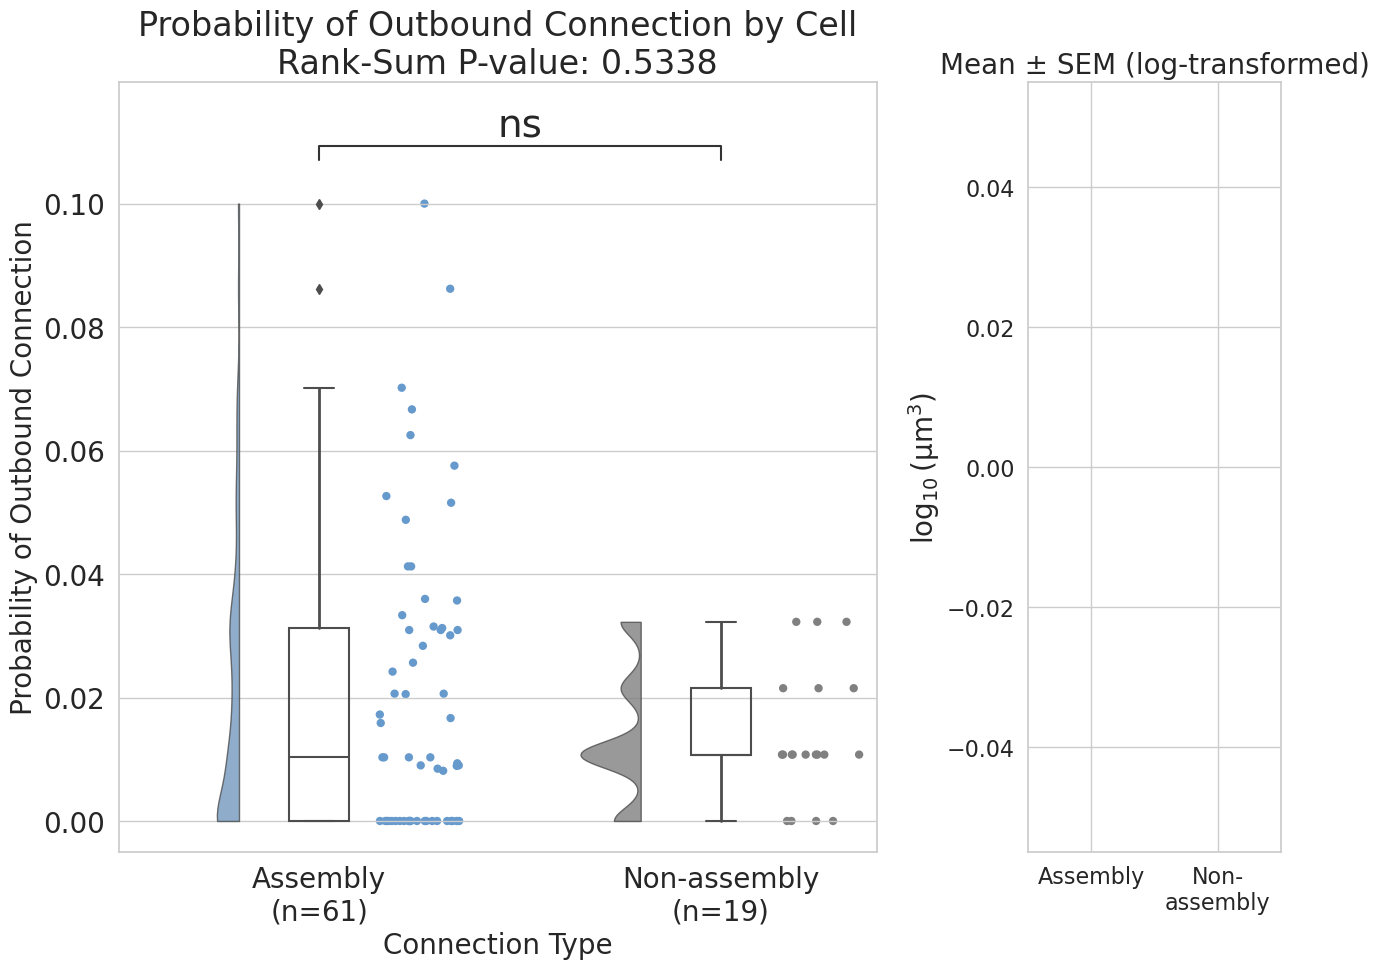

In [103]:
ranksum_signedrank_two_group_comparison(B_out,
                                        aggregation_method='cell',
                                        directionality='outbound',
                                        data_type='binary',
                                        paired=True,
                                        save=True,
                                        figure_name='Prob_Outbound_Conn'
                                        )

Wilcoxon Rank-Sum Test (unpaired, assembly > nonassembly):
Statistic: -0.4345, P-value: 0.668
No common observations found for paired analysis.
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=39) vs. Non-assembly
(n=15): Custom statistical test, P_val:6.680e-01


/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


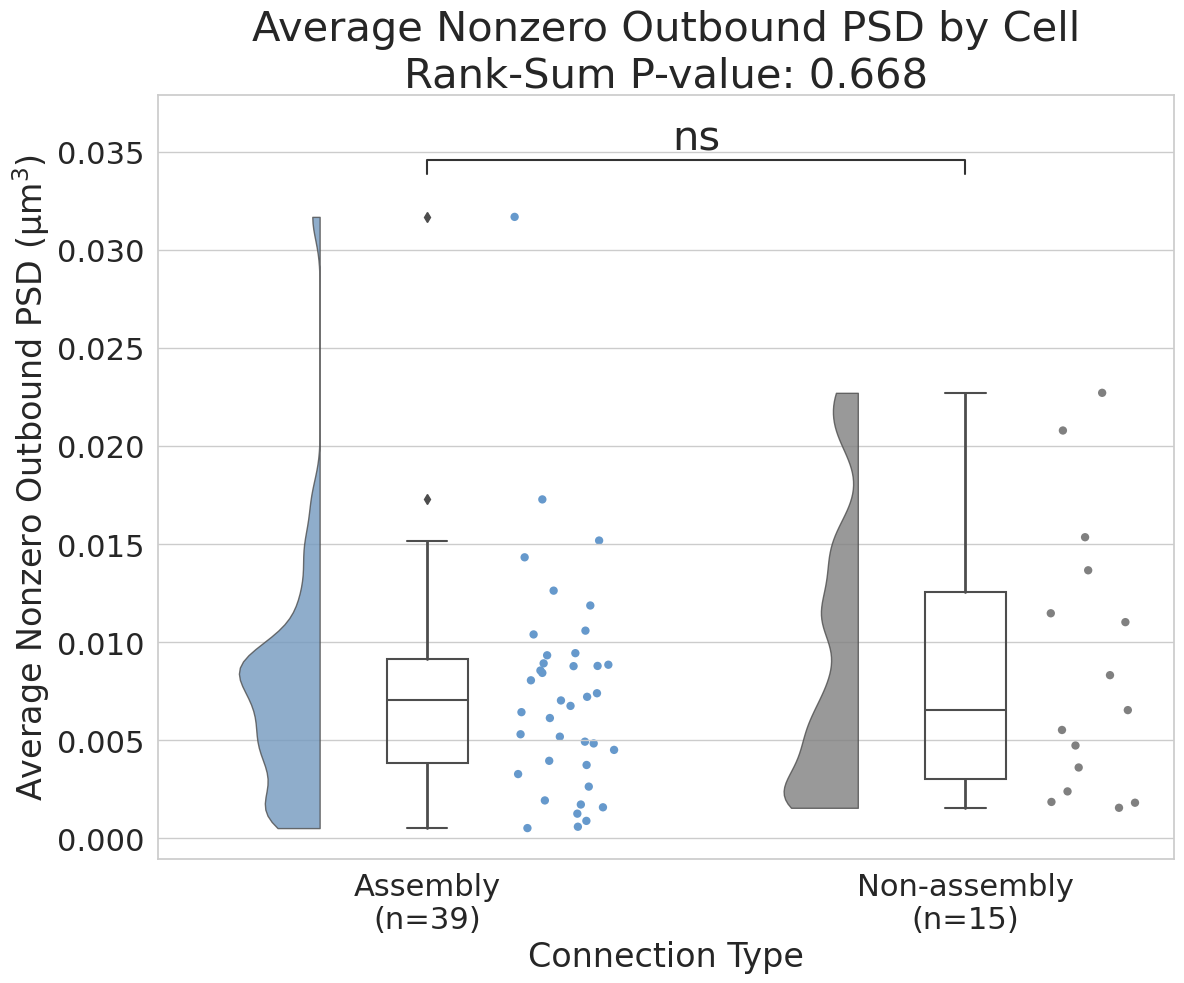

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=39) vs. Non-assembly
(n=15): Custom statistical test, P_val:6.680e-01


/tmp/ipykernel_2611/1861814550.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


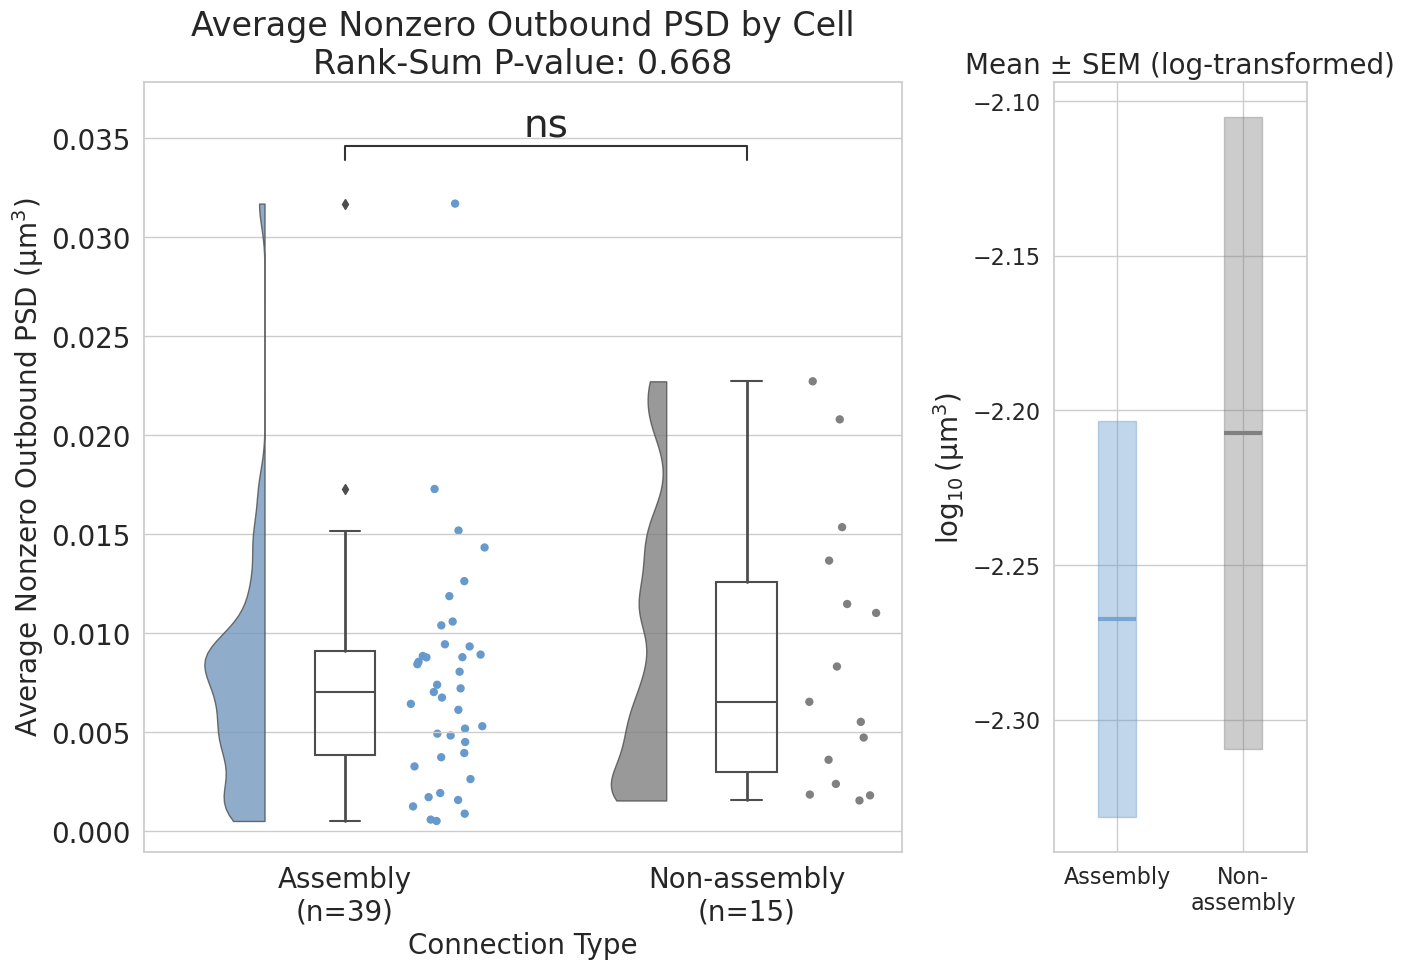

In [104]:
ranksum_signedrank_two_group_comparison(W_nonzero_out,
                                        aggregation_method='cell',
                                        directionality='outbound',
                                        data_type='summed_psd',
                                        paired=True,
                                        non_zero=True,
                                        save=True,
                                        figure_name = 'Avg_Nonzero_Outbound_PSD'
                                        )

Wilcoxon Rank-Sum Test (unpaired, assembly > nonassembly):
Statistic: 1.416, P-value: 0.07844
No common observations found for paired analysis.
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=220) vs. Non-assembly
(n=94): Custom statistical test, P_val:7.844e-02


/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


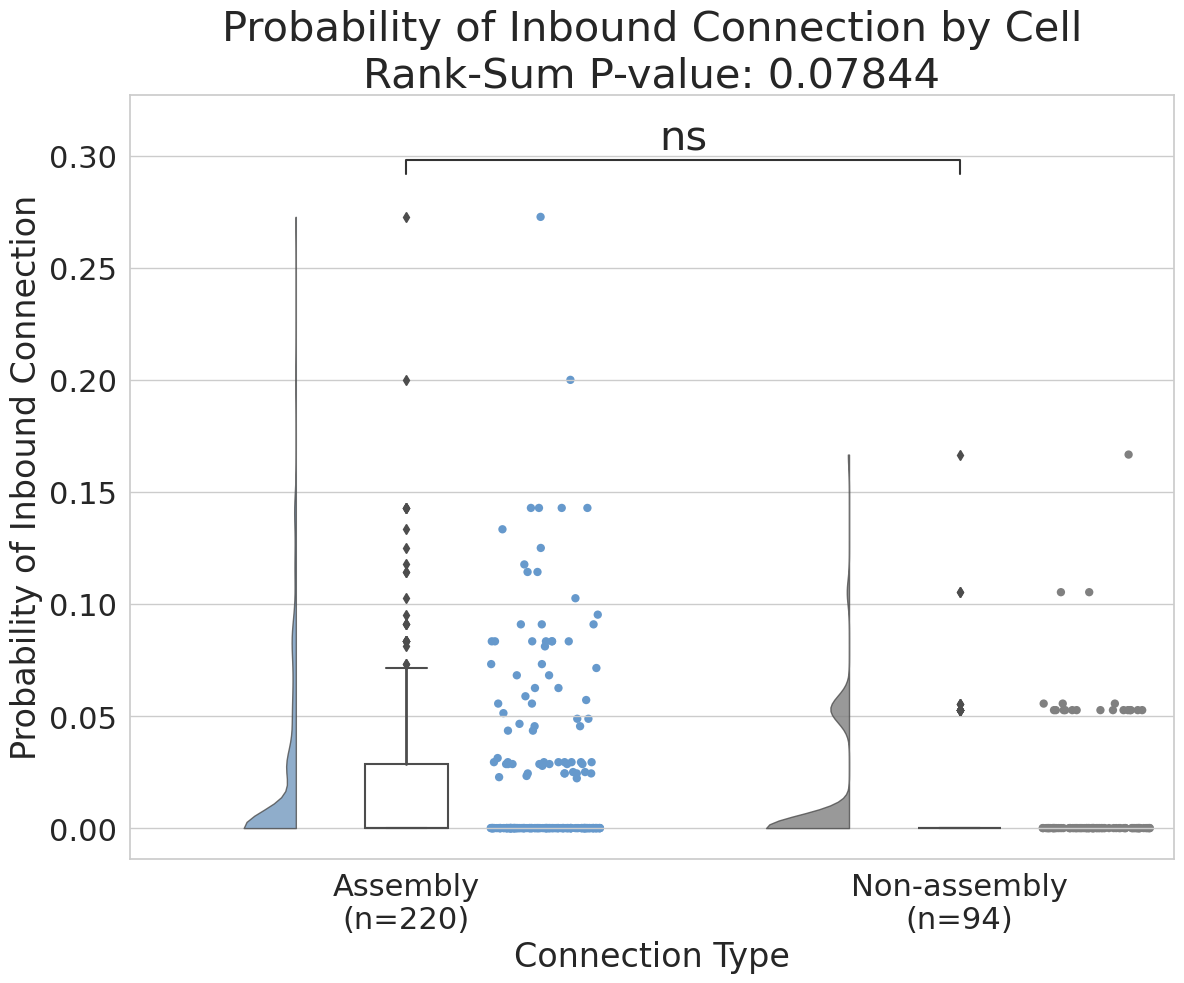

/tmp/ipykernel_2611/1861814550.py:107: RuntimeWarning: divide by zero encountered in log10
  assembly_log = np.log10(assembly_values)
/tmp/ipykernel_2611/1861814550.py:108: RuntimeWarning: divide by zero encountered in log10
  nonassembly_log = np.log10(nonassembly_values)
/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=220) vs. Non-assembly
(n=94): Custom statistical test, P_val:7.844e-02


/tmp/ipykernel_2611/1861814550.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


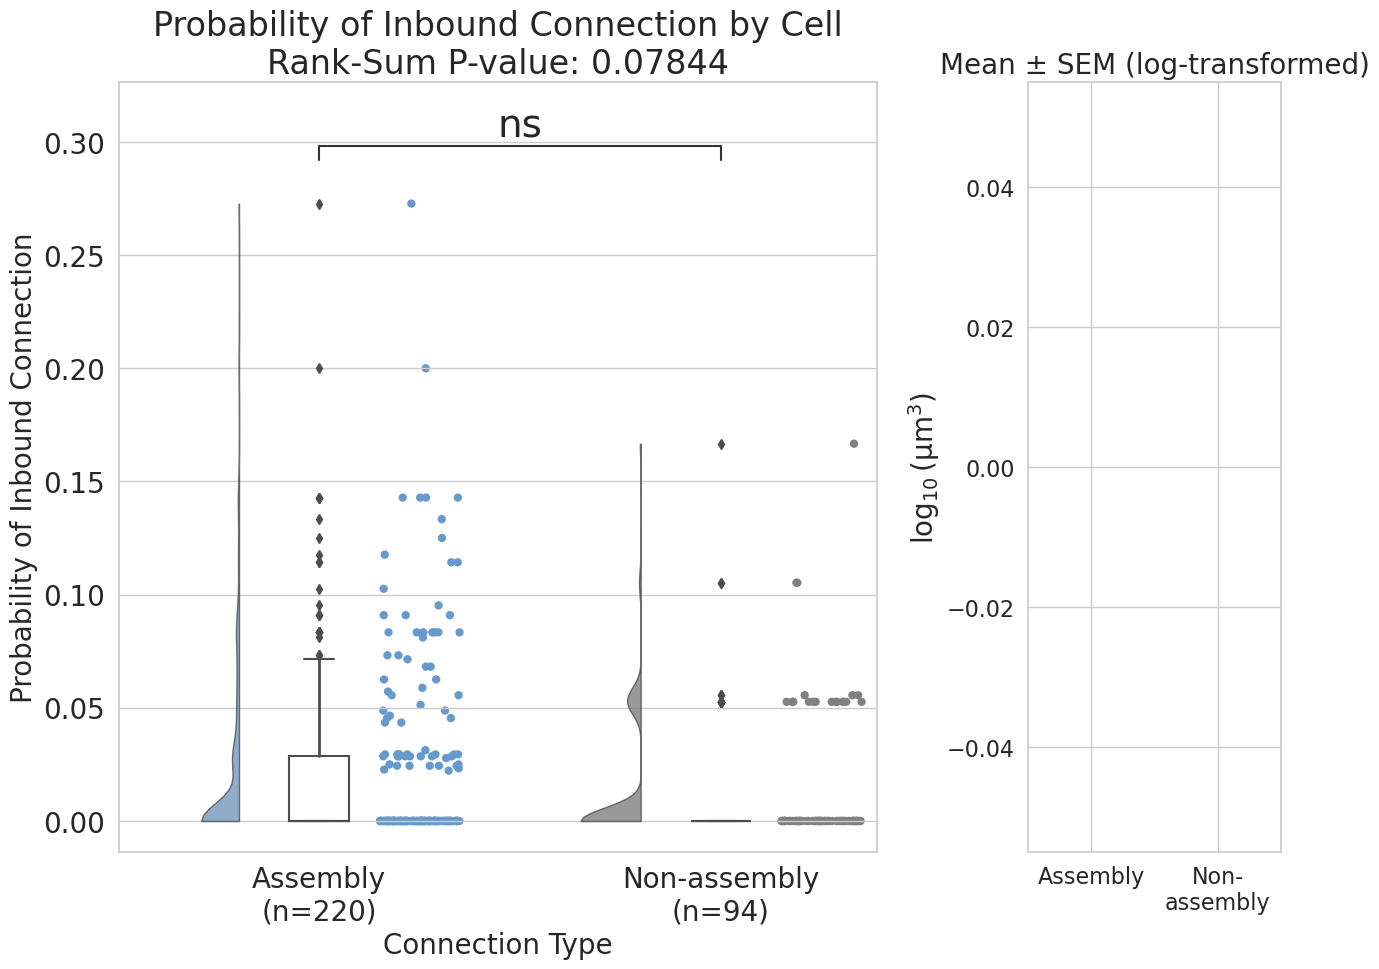

In [105]:
ranksum_signedrank_two_group_comparison(B_in,
                                        aggregation_method='cell',
                                        directionality='inbound',
                                        data_type='binary',
                                        paired=True,
                                        save=True,
                                        figure_name='Prob_Inbound_Conn'
                                        )

Wilcoxon Rank-Sum Test (unpaired, assembly > nonassembly):
Statistic: -0.8147, P-value: 0.7924
No common observations found for paired analysis.
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=71) vs. Non-assembly
(n=20): Custom statistical test, P_val:7.924e-01


/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


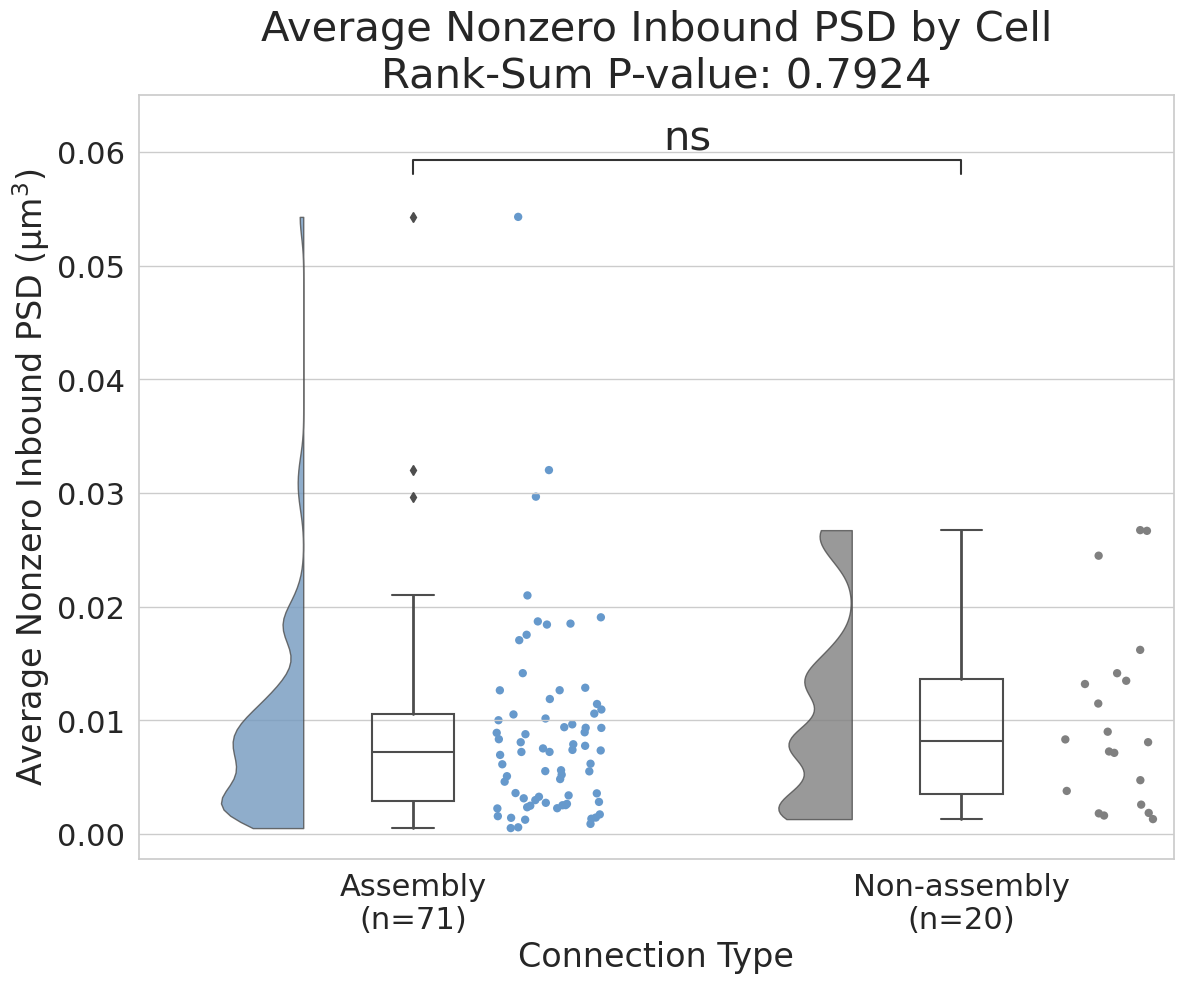

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=71) vs. Non-assembly
(n=20): Custom statistical test, P_val:7.924e-01


/tmp/ipykernel_2611/1861814550.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


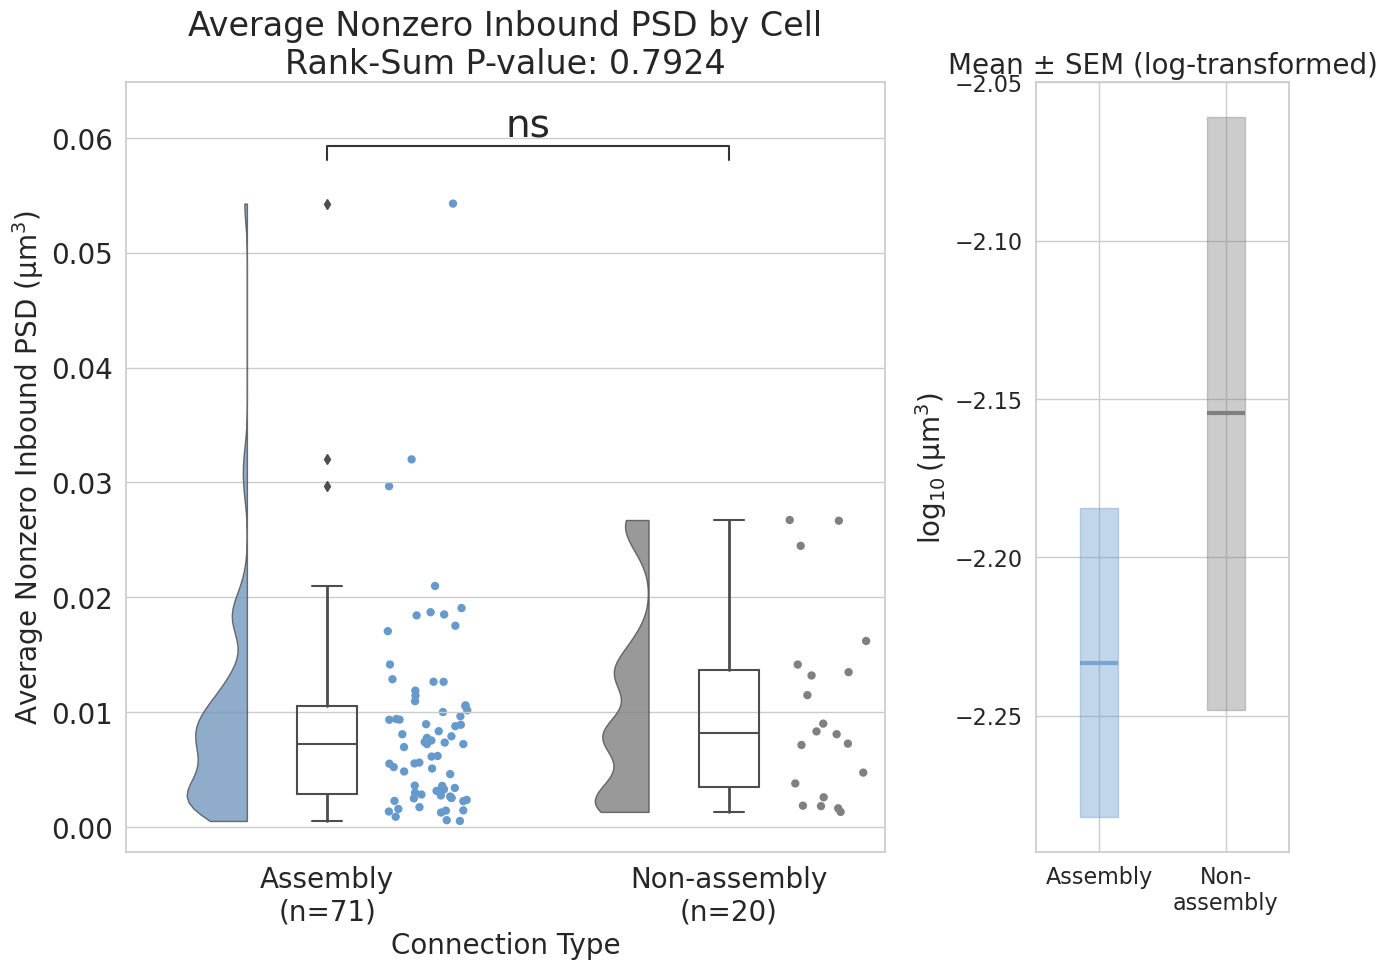

In [106]:
ranksum_signedrank_two_group_comparison(W_nonzero_in,
                                        aggregation_method='cell',
                                        directionality='inbound',
                                        data_type='summed_psd',
                                        paired=True,
                                        non_zero=True,
                                        save=True,
                                        figure_name='Avg_Nonzero_Inbound_PSD'
                                        )

## Higher-Order Connectivity Analysis: Centrality

In [107]:
def produce_centrality_plot(input_centrality_dict: dict,
                                     just_pyramidal=False,
                                     outdegree=False,
                                     indegree=False, 
                                     closeness=False, 
                                     betweenness=False,
                                     save=False,
                                     figure_name=None):
    """
    Produces a raincloud plot for centrality metrics.

    Parameters:
        input_centrality_dict (dict): Dictionary containing centrality values.
        just_pyramidal (bool): Whether to filter to pyramidal cells only.
        outdegree (bool): Whether to use outdegree centrality.
        indegree (bool): Whether to use indegree centrality.
        closeness (bool): Whether to use closeness centrality.
        betweenness (bool): Whether to use betweenness centrality.

    Returns:
        None
    """
    if outdegree and indegree:
        raise ValueError("Must either be working with outdegree or indegree.")
    if closeness and betweenness:
        raise ValueError("Must either be working with closeness or betweenness.")
    if (outdegree or indegree) and (closeness or betweenness):
        raise ValueError("Must either be working with directionality (indegree/outdegree) or higher-order (betweenness/closeness).")

    suffix = "of Co-Registered Cells"

    # Based on the connectome flags, set the correct y_label and plot title
    if outdegree:
        centrality_desc = "Outdegree_Centrality"
        suffix = "Outdegree Centrality " + suffix
        y_lab = "Outdegree Centrality"
    elif indegree:
        centrality_desc = "Indegree_Centrality"
        suffix = "Indegree Centrality " + suffix
        y_lab = "Indegree Centrality"
    elif closeness: 
        centrality_desc = "Closeness_Centrality"
        suffix = "Closeness Centrality " + suffix
        y_lab = "Closeness Centrality"
    elif betweenness:
        centrality_desc = "Betweenness_Centrality"
        suffix = "Betweenness Centrality " + suffix
        y_lab = "Betweenness Centrality"
    else:
        raise ValueError("Must Specify Degree")

    centrality_dict = {}
    for key in input_centrality_dict.keys():
        centrality_dict[key] = np.array(input_centrality_dict[key])

    all_arr = [centrality_dict['All A'], centrality_dict['No A']]
    result = stats.ranksums(centrality_dict['All A'], centrality_dict['No A'], 'greater')

    # Calculate sample sizes
    n_all_a = len(centrality_dict['All A'])
    n_no_a = len(centrality_dict['No A'])

    # Create a figure
    plt.figure(figsize=(12,10))
    sns.set_theme(style="whitegrid")

    # Prepare data for raincloud plot
    data = pd.DataFrame({
        "Values": np.concatenate(all_arr),
        "Group": [f"Assembly\n(n={n_all_a})"] * len(centrality_dict['All A']) + \
                 [f"Non-Assembly\n(n={n_no_a})"] * len(centrality_dict['No A'])
    })

    # Create the raincloud plot
    ax = pt.RainCloud(
        y="Values",
        x="Group",
        data=data,
        palette=[(.4, .6, .8, .5), 'grey'],
        width_viol=0.3,  # Adjust violin width
        alpha=0.8,  # Transparency of the cloud
        move=0.25,  # Adjust position of violins
        point_size = 6,
        orient="v"  # Horizontal orientation
    )

    # Set markings for significance
    y_labels = [f"Assembly\n(n={n_all_a})", f"Non-Assembly\n(n={n_no_a})"]
    pairs = [(y_labels[0], y_labels[1])]
    annot = Annotator(ax, 
                    pairs,
                    data=data,
                    x="Group",
                    y="Values",
                    order=y_labels # Force the order
                    )
    annot.set_pvalues([result.pvalue])
    annot.configure(text_format="star", loc="inside", fontsize=30)
    annot.annotate()

    # Add a multiline title to include the p-value, add y_label
    title = f'{suffix}\nRank-Sum P-value: {result.pvalue:.4g}'
    plt.title(title, size=32)
    plt.ylabel(y_lab, size=28)
    plt.xticks(fontsize=28)  # Adjust size of xticks
    plt.yticks(fontsize=28)  # Adjust size of yticks
    plt.xlabel("Assigned Assembly Status", size=28)

    if save == True:
        save_figure(figure_name)

    plt.tight_layout()
    plt.show()

### All Cells Proofread Connectome

In [108]:
# Pull Data from LSMM Data
with open('all_cells_proofread_connectome.json') as f:
    lsmm_json_input = json.load(f)
v1dd_data = LSMMData.LSMMData(lsmm_json_input)

data_a = v1dd_data.data
params_a = v1dd_data.params
dirs_a = v1dd_data.dirs
mappings_a = v1dd_data.mappings

Generating Connectome...


100%|██████████| 137706/137706 [00:20<00:00, 6736.26it/s]


Generating Connectome...


100%|██████████| 137706/137706 [00:27<00:00, 4954.95it/s]


In [109]:
# Calculate Centrality Measurements
binary_connectome = data_a['structural']['binary_connectome']
all_to_all_graph = nx.from_numpy_array(binary_connectome, create_using=nx.DiGraph)

indegree_centrality = nx.in_degree_centrality(all_to_all_graph)
outdegree_centrality = nx.out_degree_centrality(all_to_all_graph)
closeness_centrality = nx.closeness_centrality(all_to_all_graph, wf_improved = True)
betweenness_centrality = nx.betweenness_centrality(all_to_all_graph, normalized= True)

In [110]:
connectome_index_by_assemblies = mappings_a['connectome_indexes_by_assembly']
assembly_connectome_indexes = np.unique(np.concatenate([val for key, val in connectome_index_by_assemblies.items() if key != 'No A']))
no_assembly_connectome_indexes = np.array(list(connectome_index_by_assemblies['No A']))

# Produce Grouped Counts for Inbound and Outbound Connections
indegree_centrality_by_grouped_membership = {'No A': [], 'All A': []}
outdegree_centrality_by_grouped_membership = {'No A': [], 'All A': []}
closeness_centrality_by_grouped_membership = {'No A': [], 'All A': []}
betweenness_centrality_by_grouped_membership = {'No A': [], 'All A': []}

# Add to dictionaries to plot
for assembly_cell_idx in assembly_connectome_indexes:
    indegree_centrality_by_grouped_membership['All A'].append(indegree_centrality[assembly_cell_idx])
    outdegree_centrality_by_grouped_membership['All A'].append(outdegree_centrality[assembly_cell_idx])
    closeness_centrality_by_grouped_membership['All A'].append(closeness_centrality[assembly_cell_idx])
    betweenness_centrality_by_grouped_membership['All A'].append(betweenness_centrality[assembly_cell_idx])
for no_assembly_cell_idx in no_assembly_connectome_indexes:
    indegree_centrality_by_grouped_membership['No A'].append(indegree_centrality[no_assembly_cell_idx])
    outdegree_centrality_by_grouped_membership['No A'].append(outdegree_centrality[no_assembly_cell_idx])
    closeness_centrality_by_grouped_membership['No A'].append(closeness_centrality[no_assembly_cell_idx])
    betweenness_centrality_by_grouped_membership['No A'].append(betweenness_centrality[no_assembly_cell_idx])

In [111]:
# Save all produced sets
save_folder = 'master_freeze_produced_sets/centrality/all_cell_connectome_'
with open(f"{save_folder}indegree_centrality.pkl", "wb") as f:
    pickle.dump(indegree_centrality_by_grouped_membership, f)
with open(f"{save_folder}outdegree_centrality.pkl", "wb") as f:
    pickle.dump(outdegree_centrality_by_grouped_membership, f)
with open(f"{save_folder}closeness_centrality.pkl", "wb") as f:
    pickle.dump(closeness_centrality_by_grouped_membership, f)
with open(f"{save_folder}betweenness_centrality.pkl", "wb") as f:
    pickle.dump(betweenness_centrality_by_grouped_membership, f)

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-Assembly
(n=19): Custom statistical test, P_val:3.146e-02


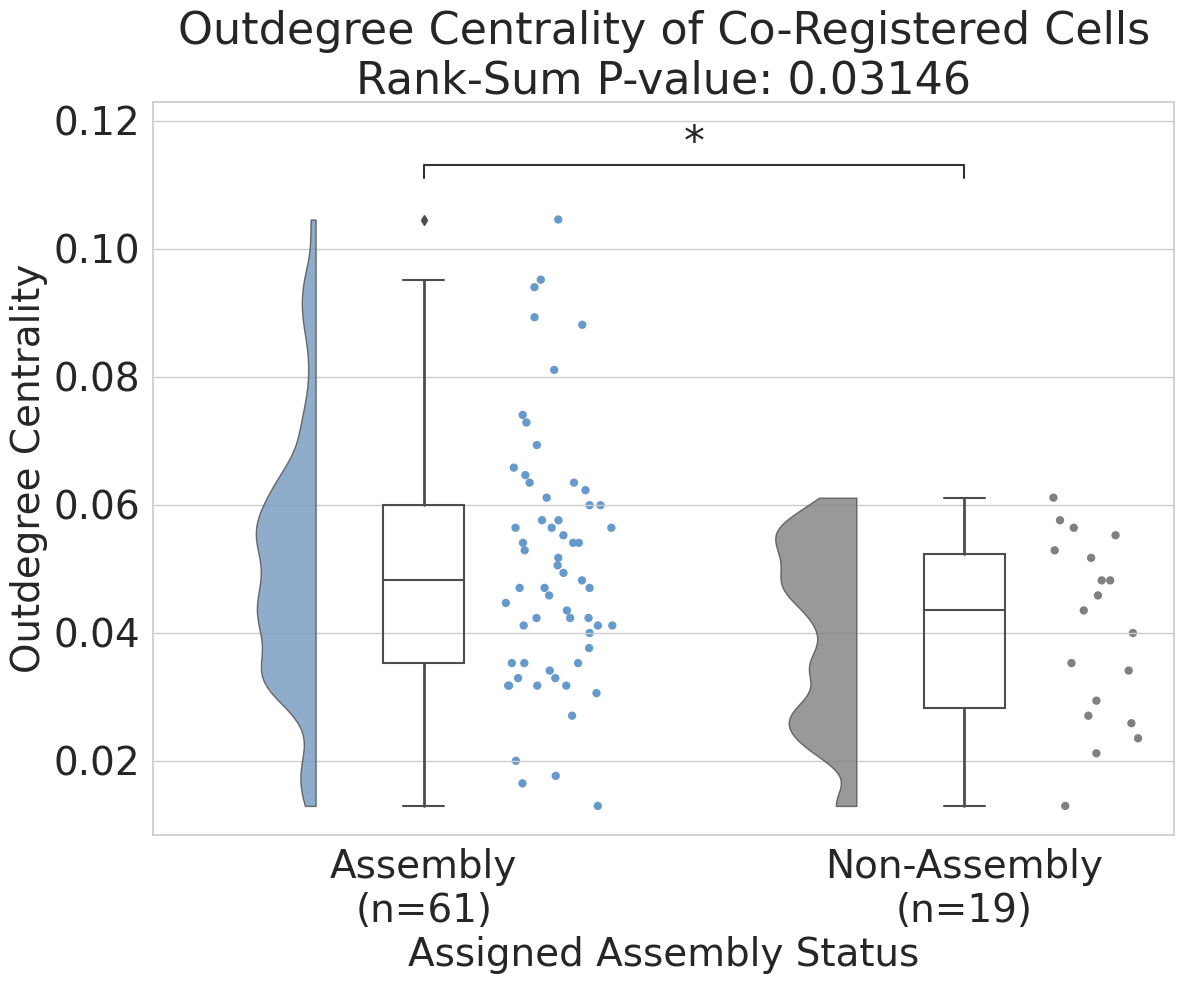

In [112]:
produce_centrality_plot(outdegree_centrality_by_grouped_membership,
                        outdegree = True, save=True, figure_name='Outdegree_Centrality_All')

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-Assembly
(n=19): Custom statistical test, P_val:4.034e-02


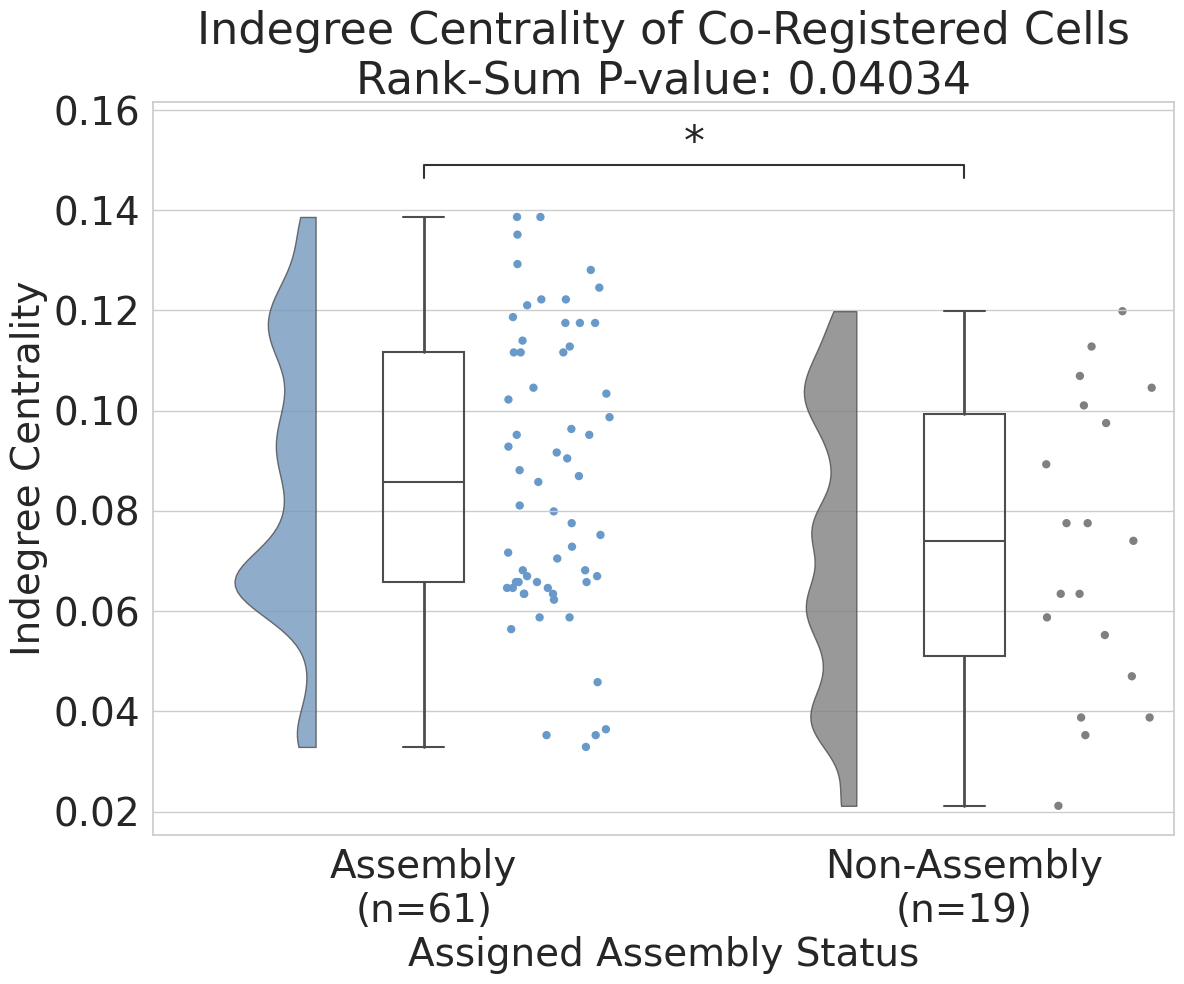

In [113]:
produce_centrality_plot(indegree_centrality_by_grouped_membership,
                        indegree = True, save=True, figure_name='Indegree_Centrality_All')

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-Assembly
(n=19): Custom statistical test, P_val:3.273e-03


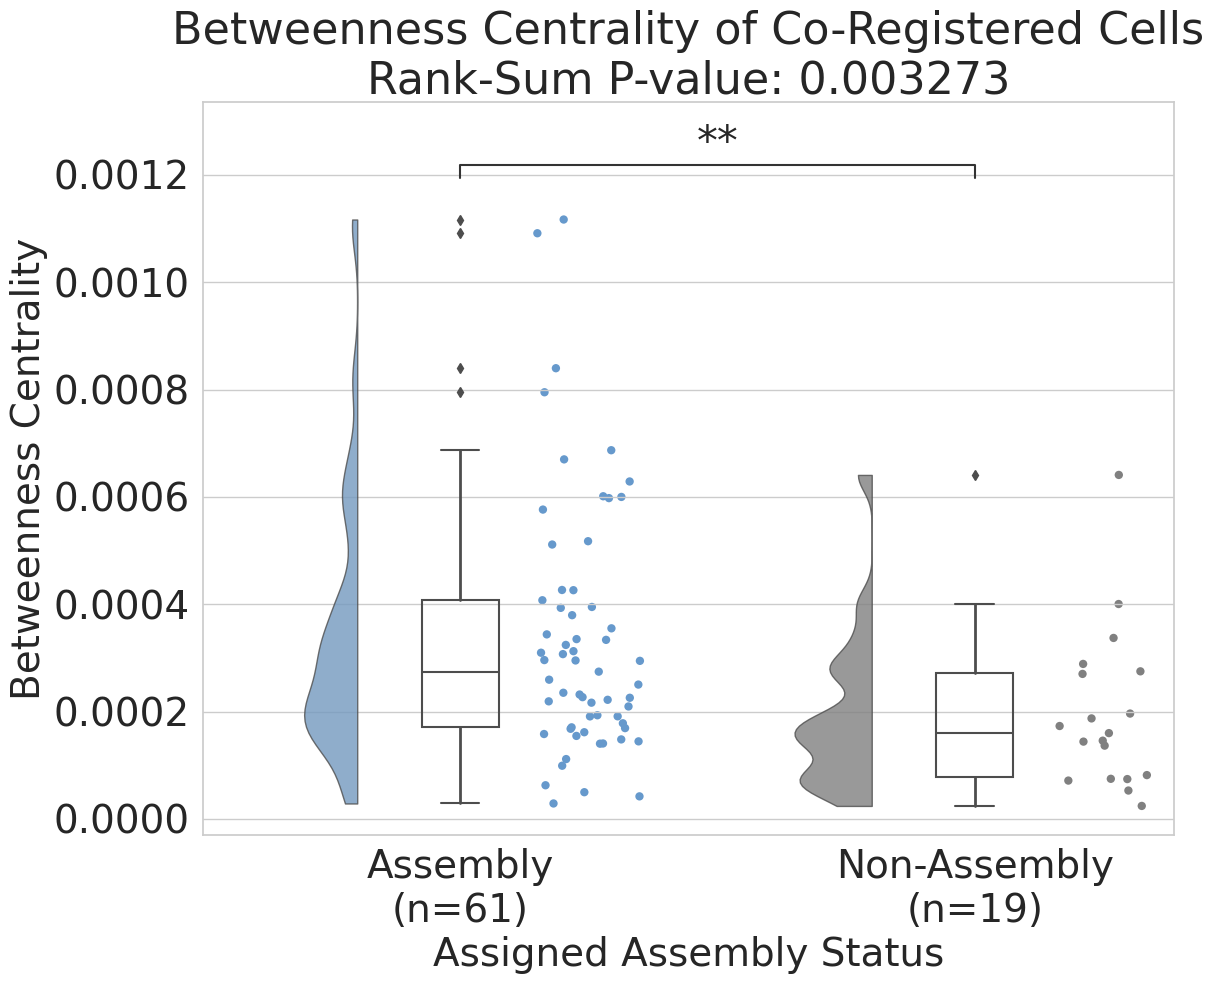

In [114]:
produce_centrality_plot(betweenness_centrality_by_grouped_membership,
                        betweenness = True, save=True, figure_name='Betweenness_Centrality_All')

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-Assembly
(n=19): Custom statistical test, P_val:7.879e-02


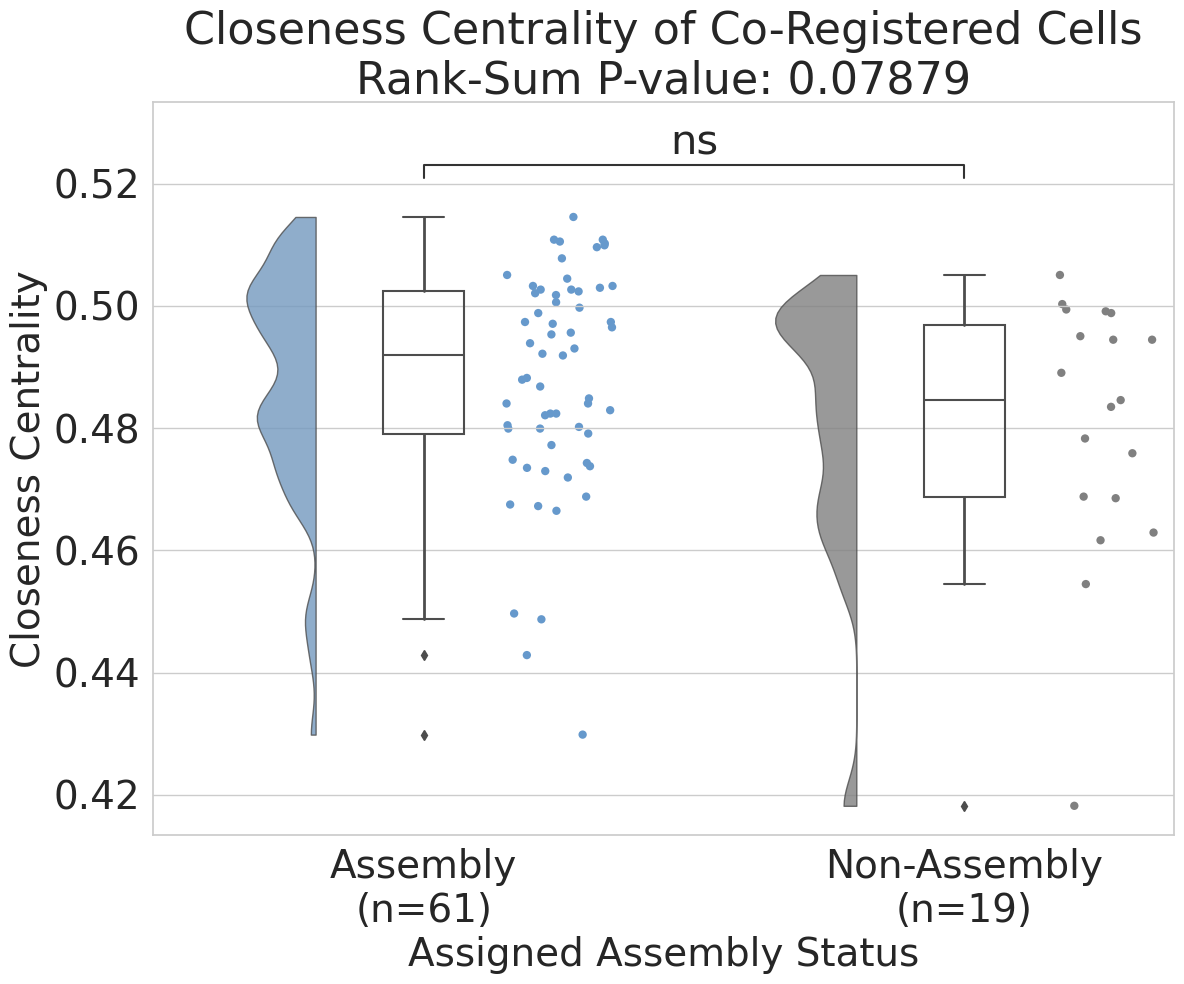

In [115]:
produce_centrality_plot(closeness_centrality_by_grouped_membership,
                        closeness = True, save=True, figure_name='Closeness_Centrality_All')

### Pyramidal Cells Proofread Connectome

In [116]:
# Pull Data from LSMM Data
with open('pyr_cells_proofread_connectome.json') as f:
    lsmm_json_input = json.load(f)
v1dd_data = LSMMData.LSMMData(lsmm_json_input)

data_a = v1dd_data.data
params_a = v1dd_data.params
dirs_a = v1dd_data.dirs
mappings_a = v1dd_data.mappings

Filtering to pyramidal cells only
459
Generating Connectome...


100%|██████████| 4565/4565 [00:00<00:00, 8195.27it/s]


Generating Connectome...


100%|██████████| 4565/4565 [00:00<00:00, 5928.31it/s]


In [117]:
# Calculate Centrality Measurements
binary_connectome = data_a['structural']['binary_connectome']
all_to_all_graph = nx.from_numpy_array(binary_connectome, create_using=nx.DiGraph)

indegree_centrality = nx.in_degree_centrality(all_to_all_graph)
outdegree_centrality = nx.out_degree_centrality(all_to_all_graph)
closeness_centrality = nx.closeness_centrality(all_to_all_graph, wf_improved = True)
betweenness_centrality = nx.betweenness_centrality(all_to_all_graph, normalized= True)

In [118]:
connectome_index_by_assemblies = mappings_a['connectome_indexes_by_assembly']
assembly_connectome_indexes = np.unique(np.concatenate([val for key, val in connectome_index_by_assemblies.items() if key != 'No A']))
no_assembly_connectome_indexes = np.array(list(connectome_index_by_assemblies['No A']))

# Produce Grouped Counts for Inbound and Outbound Connections
indegree_centrality_by_grouped_membership = {'No A': [], 'All A': []}
outdegree_centrality_by_grouped_membership = {'No A': [], 'All A': []}
closeness_centrality_by_grouped_membership = {'No A': [], 'All A': []}
betweenness_centrality_by_grouped_membership = {'No A': [], 'All A': []}

# Add to dictionaries to plot
for assembly_cell_idx in assembly_connectome_indexes:
    indegree_centrality_by_grouped_membership['All A'].append(indegree_centrality[assembly_cell_idx])
    outdegree_centrality_by_grouped_membership['All A'].append(outdegree_centrality[assembly_cell_idx])
    closeness_centrality_by_grouped_membership['All A'].append(closeness_centrality[assembly_cell_idx])
    betweenness_centrality_by_grouped_membership['All A'].append(betweenness_centrality[assembly_cell_idx])
for no_assembly_cell_idx in no_assembly_connectome_indexes:
    indegree_centrality_by_grouped_membership['No A'].append(indegree_centrality[no_assembly_cell_idx])
    outdegree_centrality_by_grouped_membership['No A'].append(outdegree_centrality[no_assembly_cell_idx])
    closeness_centrality_by_grouped_membership['No A'].append(closeness_centrality[no_assembly_cell_idx])
    betweenness_centrality_by_grouped_membership['No A'].append(betweenness_centrality[no_assembly_cell_idx])

In [119]:
# Save all produced sets
save_folder = 'master_freeze_produced_sets/centrality/pyr_only_connectome_'
with open(f"{save_folder}indegree_centrality.pkl", "wb") as f:
    pickle.dump(indegree_centrality_by_grouped_membership, f)
with open(f"{save_folder}outdegree_centrality.pkl", "wb") as f:
    pickle.dump(outdegree_centrality_by_grouped_membership, f)
with open(f"{save_folder}closeness_centrality.pkl", "wb") as f:
    pickle.dump(closeness_centrality_by_grouped_membership, f)
with open(f"{save_folder}betweenness_centrality.pkl", "wb") as f:
    pickle.dump(betweenness_centrality_by_grouped_membership, f)

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-Assembly
(n=19): Custom statistical test, P_val:2.876e-02


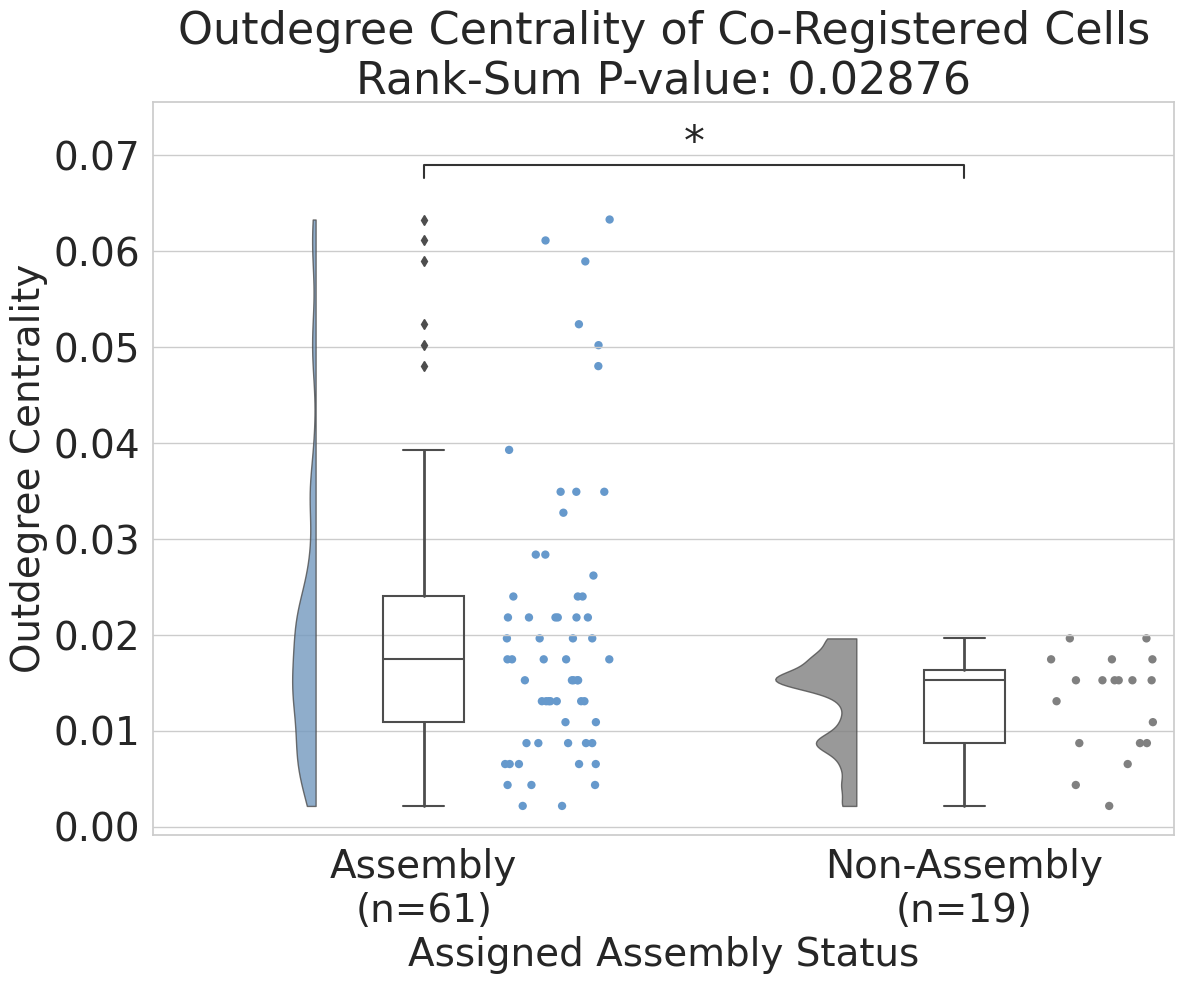

In [120]:
produce_centrality_plot(outdegree_centrality_by_grouped_membership,
                        outdegree = True,
                        just_pyramidal = True, 
                        save=True,
                        figure_name='Outdegree_Centrality_Pyr')

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-Assembly
(n=19): Custom statistical test, P_val:6.207e-02


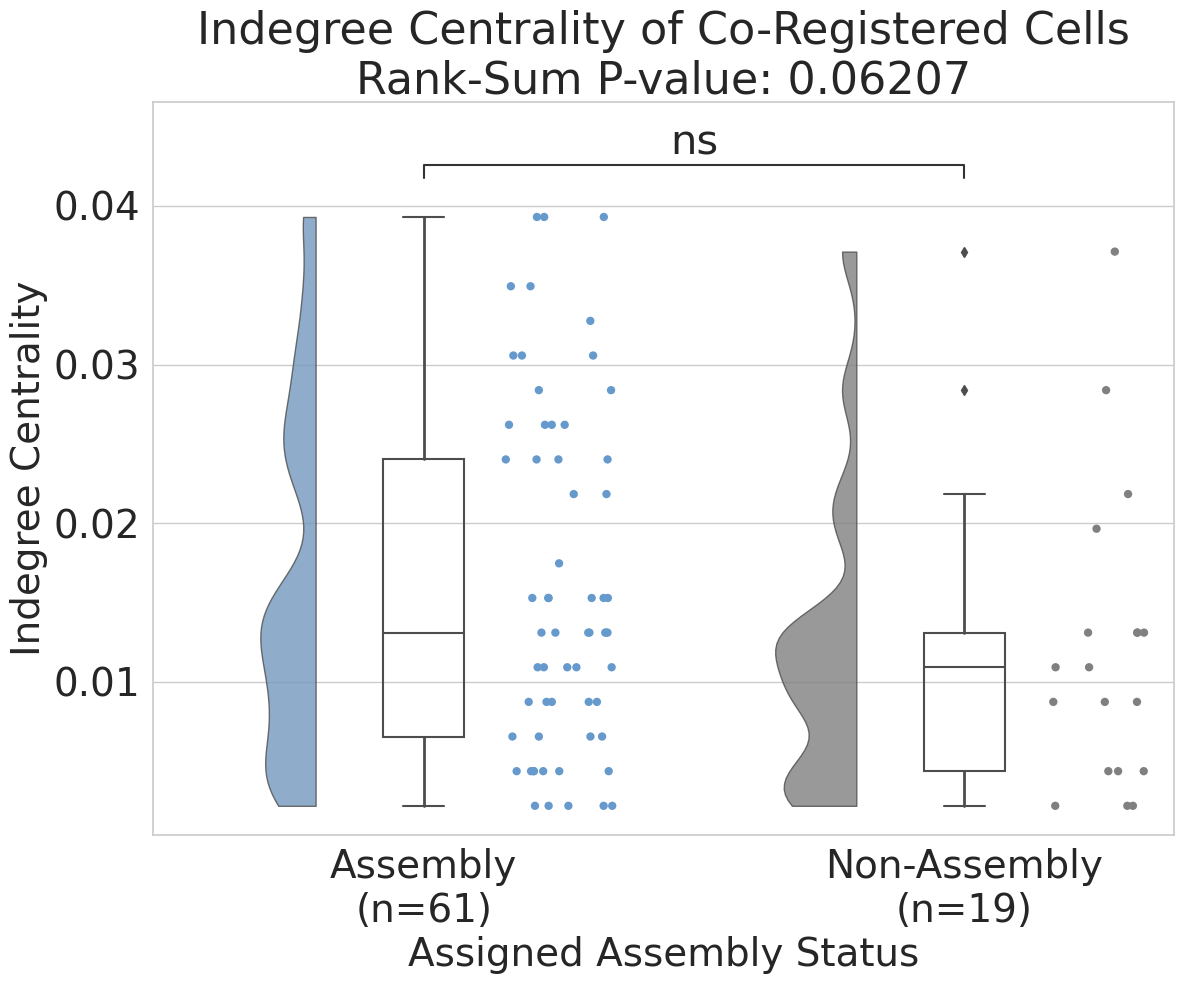

In [121]:
produce_centrality_plot(indegree_centrality_by_grouped_membership,
                        indegree = True,
                        just_pyramidal = True, 
                        save=True,
                        figure_name='Indegree_Centrality_Pyr')

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-Assembly
(n=19): Custom statistical test, P_val:2.913e-02


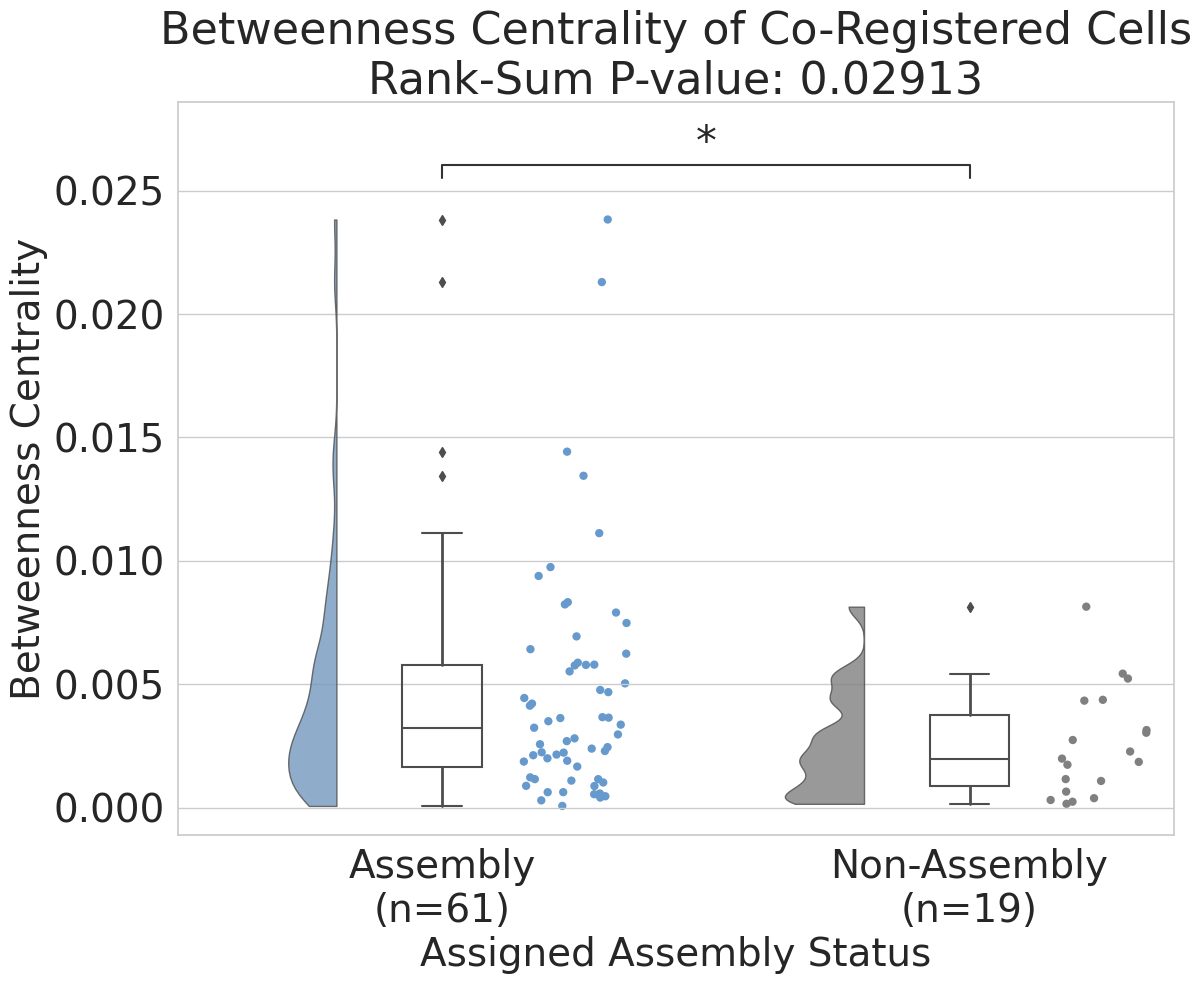

In [122]:
produce_centrality_plot(betweenness_centrality_by_grouped_membership,
                        betweenness = True,
                        just_pyramidal = True, 
                        save=True,
                        figure_name='Betweenness_Centrality_Pyr')

/home/stefan.berteau/.conda/envs/stat_conn_jax/lib/python3.12/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-Assembly
(n=19): Custom statistical test, P_val:1.998e-01


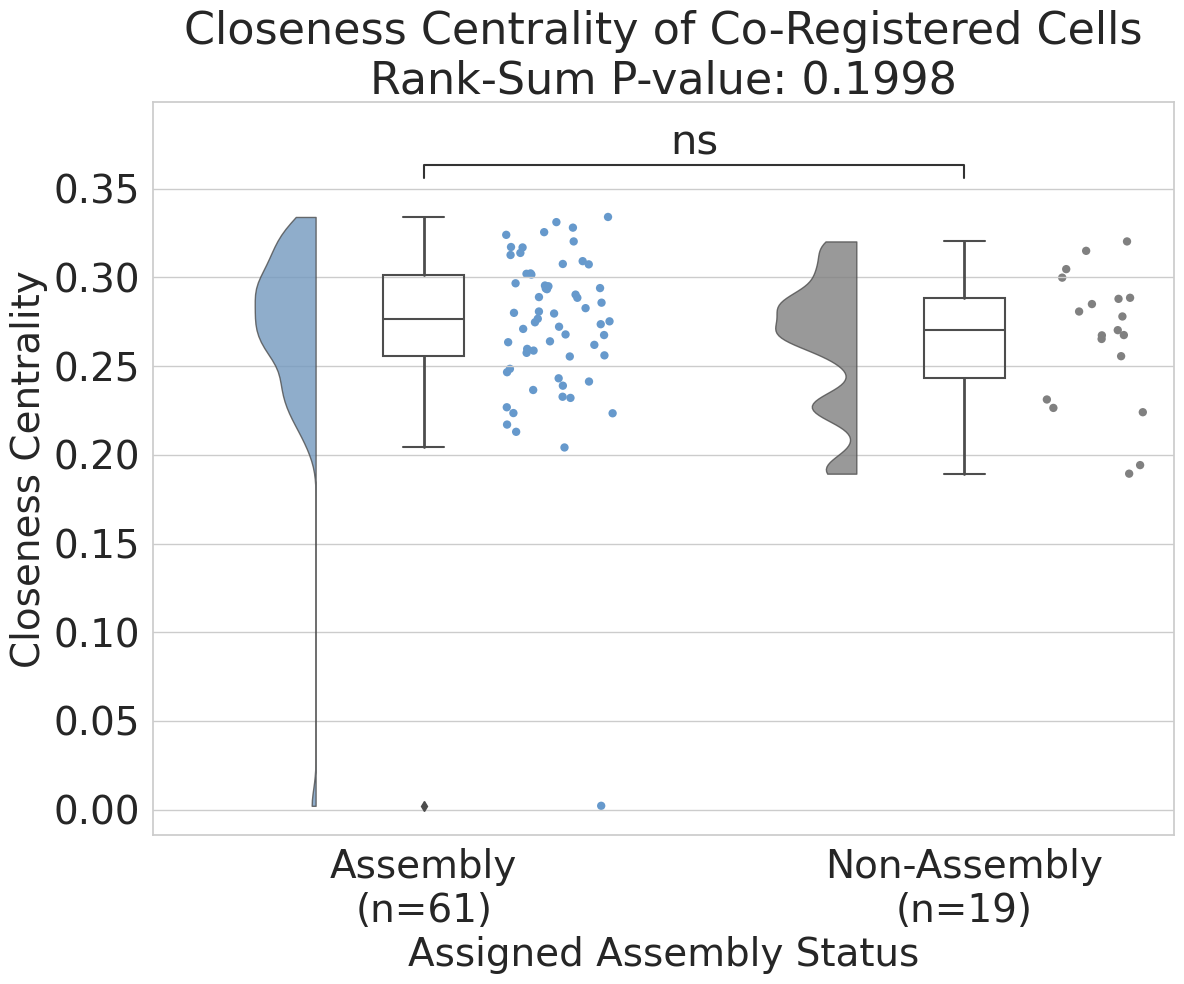

In [123]:
produce_centrality_plot(closeness_centrality_by_grouped_membership,
                        closeness = True,
                        just_pyramidal = True, 
                        save=True,
                        figure_name='Closeness_Centrality_Pyr')

## Higher-Order Conectivity Analysis: Chain Motifs

### Prep Data

In [124]:
with open('all_cells_proofread_connectome.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
# with open('pyr_rect.data', 'wb') as f:
#     pickle.dump(my_data, f)

data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

Generating Connectome...


100%|██████████| 137706/137706 [00:20<00:00, 6780.13it/s]


Generating Connectome...


100%|██████████| 137706/137706 [00:27<00:00, 5026.06it/s]


In [125]:
# Make a graph
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
post_cell_table = data_a['structural']['post_cell'].copy()
post_cell_table['connectome_index'] = post_cell_table.index

synapse_table = data_a['structural']['synapse']
# adjacency_matrix = data_a['structural']['binary_connectome']
binary_connectome = data_a['structural']['binary_connectome']

index_to_root_id = [mappings_a['connectome_index_to_root_id'][i] for i in range(binary_connectome.shape[0])]

summed_size_connectome = data_a['structural']['summed_size_connectome']
summed_size_connectome_df = pd.DataFrame(
    summed_size_connectome,
    index=index_to_root_id,
    columns=index_to_root_id
)

pyr_graph = nx.from_numpy_array(binary_connectome, create_using=nx.DiGraph)
pyr_graph = nx.relabel_nodes(pyr_graph, {i: index_to_root_id[i] for i in range(len(index_to_root_id))})

# Or uncomment below to generate new motif analysis results (Can take quite a while on larger graphs)
# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph= pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
              """)

chain_results = executor.find(chain_defs)

two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

### Pool necessary Data
chain_count_string_array = ['pyr_cell_2chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]
individual_post_assembly_indexes = [mappings_a['post_connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,16)]

coregistered_post_cell_indexes = mappings_a['assemblies_by_post_connectome_index'].keys()
coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
no_a_post_cell_indexes = mappings_a['post_connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))
pooled_assembly_post_indexes = list(set(coregistered_post_cell_indexes) - set(no_a_post_cell_indexes))

assembly_to_root_ids = mappings_a['pt_root_ids_by_assembly']
assembly_root_ids_set = set(mappings_a['assemblies_by_pt_root_id'].keys())

# Filter synapses_table to only synapses between two assembly cells (including No A)
synapses_df = synapse_table[synapse_table['pre_pt_root_id'].isin(assembly_root_ids_set)]
synapses_df = synapses_df[synapses_df['post_pt_root_id'].isin(assembly_root_ids_set)]

# Filter cell tables to only assembly cells (including 'No A')
assembly_cell_table = cell_table[cell_table['pt_root_id'].isin(assembly_root_ids_set)]
assembly_post_cell_table = post_cell_table[post_cell_table['pt_root_id'].isin(assembly_root_ids_set)]

assembly_pre_root_ids = set(assembly_cell_table['pt_root_id'].values)
assembly_post_root_ids = set(assembly_post_cell_table['pt_root_id'].values)
all_root_ids = assembly_pre_root_ids | assembly_post_root_ids

6052393it [00:42, 143493.86it/s]
100%|██████████| 6052393/6052393 [00:11<00:00, 513946.66it/s] 


In [126]:
# Initialize dictionaries to store weights and binary connectivity
W_chain_excitatory = {}
W_chain_inhibitory = {}
B_chain_excitatory = {}
B_chain_inhibitory = {}

# Define all potential (pre-cell, post-cell) pairs with excitatory and inhibitory chain types
for j in all_root_ids:
    for i in all_root_ids:
        if j != i:  # Exclude autapses
            W_chain_excitatory[(j, i)] = 0
            W_chain_inhibitory[(j, i)] = 0
            B_chain_excitatory[(j, i)] = 0
            B_chain_inhibitory[(j, i)] = 0

pt_root_id_to_classification = cell_table.set_index('pt_root_id')['classification_system'].to_dict()

# Process each row in `two_chain_results_array` to populate weights and binary connectivity
for _, row in enumerate(two_chain_results_array):
    pre_cell, mid_cell, post_cell = row  # j: pre-cell, k: middle cell, i: post-cell
    if pre_cell in all_root_ids and post_cell in all_root_ids:
    # Determine chain type (excitatory if middle cell is in excitatory set, else inhibitory)
        if pt_root_id_to_classification[mid_cell] == 'inhibitory':
            W_chain = W_chain_inhibitory
            B_chain = B_chain_inhibitory
        elif pt_root_id_to_classification[mid_cell] == 'excitatory':
            W_chain = W_chain_excitatory
            B_chain = B_chain_excitatory
    # Get synapse weights for connections j -> k and k -> i
        w_jk = summed_size_connectome_df.loc[pre_cell, mid_cell] * (9 * 9 * 45) / (10**9) # cubic micrometers
        w_ki = summed_size_connectome_df.loc[mid_cell, post_cell] * (9 * 9 * 45) / (10**9) # cubic micrometers
    
    # Updates weights and binary connectivity
        W_chain[(pre_cell, post_cell)] += (w_jk * w_ki)
        B_chain[(pre_cell, post_cell)] = 1

In [ ]:
## PARIWISE NONZERO PSD and CONNECTION PROBABILITY BY CONNECTION TYPE
# Aggregate nonzero pairs and calculate connectivity probabilities by connection type
W_chain_nonzero_pairwise_excitatory = {}
W_chain_nonzero_pairwise_inhibitory = {}
B_chain_pairwise_excitatory = {}
B_chain_pairwise_inhibitory = {}

for cond_function in comparison_functions:
    # Initialize dictionaries per connection type
    W_chain_nonzero_pairwise_excitatory[cond_function.__name__] = {}
    W_chain_nonzero_pairwise_inhibitory[cond_function.__name__] = {}
    B_chain_pairwise_excitatory[cond_function.__name__] = {}
    B_chain_pairwise_inhibitory[cond_function.__name__] = {}

    # Process all (j, i) pairs from excitatory/inhibitory dictionaries
    for (j, i) in W_chain_excitatory.keys():
        if cond_function(j, i, A):
            # Set binary connectivity for each connection type
            B_chain_pairwise_excitatory[cond_function.__name__][(j, i)] = 1 if W_chain_excitatory[(j, i)] > 0 else 0
            B_chain_pairwise_inhibitory[cond_function.__name__][(j, i)] = 1 if W_chain_inhibitory[(j, i)] > 0 else 0
            
            # Store only nonzero weights
            if W_chain_excitatory[(j, i)] > 0:
                W_chain_nonzero_pairwise_excitatory[cond_function.__name__][(j, i)] = W_chain_excitatory[(j, i)]
            if W_chain_inhibitory[(j, i)] > 0:
                W_chain_nonzero_pairwise_inhibitory[cond_function.__name__][(j, i)] = W_chain_inhibitory[(j, i)]


## ADD IN NORMALIZATION BY # POTENTIAL CONNECTIONS
## Inbound, Outbound Collections
from collections import Counter

classification_map = cell_table.set_index('connectome_index')['classification_system'].to_dict() # Map to tell us if its Excitatory or Inhibitory 
backup_assembly_pre_root_ids = assembly_pre_root_ids
backup_assembly_post_root_ids = assembly_post_root_ids
classification_counts = Counter(classification_map.values())

num_excitatory = classification_counts.get('excitatory', 0)
num_inhibitory = classification_counts.get('inhibitory', 0)
# Aggregate chain weights and connectivity for outbound and inbound paths
W_nonzero_chain_out_excitatory = {}
W_nonzero_chain_out_inhibitory = {}
W_nonzero_chain_in_excitatory = {}
W_nonzero_chain_in_inhibitory = {}
B_chain_out_excitatory = {}
B_chain_out_inhibitory = {}
B_chain_in_excitatory = {}
B_chain_in_inhibitory = {}

# Iterate through connection types in C (e.g., assembly, nonassembly)
for connection_type in comparison_functions:
    # Initialize per connection type dictionaries
    W_nonzero_chain_out_excitatory[connection_type.__name__] = {}
    W_nonzero_chain_out_inhibitory[connection_type.__name__] = {}
    W_nonzero_chain_in_excitatory[connection_type.__name__] = {}
    W_nonzero_chain_in_inhibitory[connection_type.__name__] = {}
    B_chain_out_excitatory[connection_type.__name__] = {}
    B_chain_out_inhibitory[connection_type.__name__] = {}
    B_chain_in_excitatory[connection_type.__name__] = {}
    B_chain_in_inhibitory[connection_type.__name__] = {}
    # Outbound analysis (from pre-cell j to post-cell i through middle cell k)
    for j in all_root_ids:
        potential_partners_out = {i for i in all_root_ids if i != j and connection_type(j, i, A)}
        if potential_partners_out:  # Only proceed if valid post-cell partners exist
            realized_chains_count_excitatory = 0
            realized_chains_count_inhibitory = 0
            sum_weights_excitatory = 0
            sum_weights_inhibitory = 0
            potential_excitatory_chains = (num_excitatory - 2) * (len(potential_partners_out)) # maybe middle cell is in set of coregistered that satisfies condition
            potential_inhibitory_chains = num_inhibitory * len(potential_partners_out)
            for i in potential_partners_out:
                temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == j) & (two_chain_results_array[:, 2] == i)]

                for chain in temporary_chain_results:
                    j, k, i = chain
                    w_jk = summed_size_connectome_df.loc[j, k]
                    w_ki = summed_size_connectome_df.loc[k, i]
                    # Check chain type and accumulate only when both segments have valid weights
                    if pt_root_id_to_classification.get(k) == 'excitatory':
                        sum_weights_excitatory += w_jk * w_ki
                        realized_chains_count_excitatory += 1  # Increase excitatory chain count
                    elif pt_root_id_to_classification.get(k) == 'inhibitory':
                        sum_weights_inhibitory += w_jk * w_ki
                        realized_chains_count_inhibitory += 1  # Increase inhibitory chain count

            # Normalize weights by realized chain count only if nonzero
            if realized_chains_count_excitatory > 0:
                W_nonzero_chain_out_excitatory[connection_type.__name__][j] = sum_weights_excitatory / realized_chains_count_excitatory
            if realized_chains_count_inhibitory > 0:
                W_nonzero_chain_out_inhibitory[connection_type.__name__][j] = sum_weights_inhibitory / realized_chains_count_inhibitory

            # Calculate binary connectivity only if there are potential partners
            B_chain_out_excitatory[connection_type.__name__][j] = realized_chains_count_excitatory / potential_excitatory_chains if len(potential_partners_out) > 0 else 0
            B_chain_out_inhibitory[connection_type.__name__][j] = realized_chains_count_inhibitory / potential_inhibitory_chains if len(potential_partners_out) > 0 else 0
    
    for i in all_root_ids:
        potential_partners_in = {j for j in all_root_ids if i != j and connection_type(j, i, A)}
        if potential_partners_in:  # Only proceed if valid post-cell partners exist
            realized_chains_count_excitatory = 0
            realized_chains_count_inhibitory = 0
            sum_weights_excitatory = 0
            sum_weights_inhibitory = 0
            potential_excitatory_chains = (num_excitatory - 2) * (len(potential_partners_in)) # maybe middle cell is in set of coregistered that satisfies condition
            potential_inhibitory_chains = num_inhibitory * len(potential_partners_in)
            for j in potential_partners_in:
                temporary_chain_results = two_chain_results_array[(two_chain_results_array[:, 0] == j) & (two_chain_results_array[:, 2] == i)]

                for chain in temporary_chain_results:
                    j, k, i = chain
                    w_jk = summed_size_connectome_df.loc[j, k]
                    w_ki = summed_size_connectome_df.loc[k, i]
                    # Check chain type and accumulate only when both segments have valid weights
                    if pt_root_id_to_classification.get(k) == 'excitatory':
                        sum_weights_excitatory += w_jk * w_ki
                        realized_chains_count_excitatory += 1  # Increase excitatory chain count
                    elif pt_root_id_to_classification.get(k) == 'inhibitory':
                        sum_weights_inhibitory += w_jk * w_ki
                        realized_chains_count_inhibitory += 1  # Increase inhibitory chain count

            # Normalize weights by realized chain count only if nonzero
            if realized_chains_count_excitatory > 0:
                W_nonzero_chain_in_excitatory[connection_type.__name__][i] = sum_weights_excitatory / realized_chains_count_excitatory
            if realized_chains_count_inhibitory > 0:
                W_nonzero_chain_in_inhibitory[connection_type.__name__][i] = sum_weights_inhibitory / realized_chains_count_inhibitory

            # Calculate binary connectivity only if there are potential partners
            B_chain_in_excitatory[connection_type.__name__][i] = realized_chains_count_excitatory / potential_excitatory_chains if len(potential_partners_in) > 0 else 0
            B_chain_in_inhibitory[connection_type.__name__][i] = realized_chains_count_inhibitory / potential_inhibitory_chains if len(potential_partners_in) > 0 else 0

In [ ]:
# Save all produced sets
save_folder = 'master_freeze_produced_sets/chain_connections/'
with open(f"{save_folder}W_chain_nonzero_pairwise_excitatory.pkl", "wb") as f:
    pickle.dump(W_chain_nonzero_pairwise_excitatory, f)
with open(f"{save_folder}W_chain_nonzero_pairwise_inhibitory.pkl", "wb") as f:
    pickle.dump(W_chain_nonzero_pairwise_inhibitory, f)
with open(f"{save_folder}B_chain_pairwise_excitatory.pkl", "wb") as f:
    pickle.dump(B_chain_pairwise_excitatory, f)
with open(f"{save_folder}B_chain_pairwise_inhibitory.pkl", "wb") as f:
    pickle.dump(B_chain_pairwise_inhibitory, f)
with open(f"{save_folder}W_nonzero_chain_out_excitatory.pkl", "wb") as f:
    pickle.dump(W_nonzero_chain_out_excitatory, f)
with open(f"{save_folder}W_nonzero_chain_out_inhibitory.pkl", "wb") as f:
    pickle.dump(W_nonzero_chain_out_inhibitory, f)
with open(f"{save_folder}W_nonzero_chain_in_excitatory.pkl", "wb") as f:
    pickle.dump(W_nonzero_chain_in_excitatory, f)
with open(f"{save_folder}W_nonzero_chain_in_inhibitory.pkl", "wb") as f:
    pickle.dump(W_nonzero_chain_in_inhibitory, f)
with open(f"{save_folder}B_chain_out_excitatory.pkl", "wb") as f:
    pickle.dump(B_chain_out_excitatory, f)
with open(f"{save_folder}B_chain_out_inhibitory.pkl", "wb") as f:
    pickle.dump(B_chain_out_inhibitory, f)
with open(f"{save_folder}B_chain_in_excitatory.pkl", "wb") as f:
    pickle.dump(B_chain_in_excitatory, f)
with open(f"{save_folder}B_chain_in_inhibitory.pkl", "wb") as f:
    pickle.dump(B_chain_in_inhibitory, f)

### Plot Results

In [ ]:
excitatory_contingency_table = construct_contingency_table(B_chain_pairwise_excitatory, groups)
inhibitory_contingency_table = construct_contingency_table(B_chain_pairwise_inhibitory, groups)

print("Excitatory Chain Contingency Table:")
chi_squared_analysis(excitatory_contingency_table, save=True, figure_name='Prob_Conn_by_Conn_Type_E_Chains')
chi_squared_analysis_v2(excitatory_contingency_table, save=True, figure_name='Prob_Conn_by_Conn_Type_E_Chains_v2')

print("\nInhibitory Chain Contingency Table:")
chi_squared_analysis(inhibitory_contingency_table, save=True, figure_name='Prob_Conn_by_Conn_Type_I_Chains')
chi_squared_analysis_v2(inhibitory_contingency_table, save=True, figure_name='Prob_Conn_by_Conn_Type_I_Chains_v2')

In [ ]:
ranksum_signedrank_two_group_comparison(W_chain_nonzero_pairwise_excitatory,
                                        aggregation_method='connection',
                                        data_type='summed_psd',
                                        non_zero=True,
                                        chain_test=True,
                                        chain_description= "Excitatory",
                                        save=True,
                                        figure_name='Nonzero_PSD_by_Conn_E_Chain'
                                        )

ranksum_signedrank_two_group_comparison(W_chain_nonzero_pairwise_inhibitory,
                                        aggregation_method='connection',
                                        data_type='summed_psd',
                                        non_zero=True,
                                        chain_test=True,
                                        chain_description= "Inhibitory",
                                        save=True,
                                        figure_name='Nonzero_PSD_by_Conn_I_Chain'
                                        )

In [ ]:
ranksum_signedrank_two_group_comparison(B_chain_out_excitatory,
                                        aggregation_method='cell',
                                        directionality='outbound',
                                        data_type='binary',
                                        paired=True,
                                        chain_test=True,
                                        chain_description= "Excitatory",
                                        save=True,
                                        figure_name='Prob_Outbound_Conn_E_Chain'
                                        )

ranksum_signedrank_two_group_comparison(B_chain_out_inhibitory,
                                        aggregation_method='cell',
                                        directionality='outbound',
                                        data_type='binary',
                                        paired=True,
                                        chain_test=True,
                                        chain_description= "Inhibitory",
                                        save=True,
                                        figure_name='Prob_Outbound_Conn_I_Chain'
                                        )

In [ ]:
ranksum_signedrank_two_group_comparison(W_nonzero_chain_out_excitatory,
                                        aggregation_method='cell',
                                        directionality='outbound',
                                        data_type='summed_psd',
                                        non_zero=True,
                                        paired=True,
                                        chain_test=True,
                                        chain_description= "Excitatory",
                                        save=True,
                                        figure_name='Avg_Nonzero_Outbound_PSD_E_Chain'
                                        )

ranksum_signedrank_two_group_comparison(W_nonzero_chain_out_inhibitory,
                                        aggregation_method='cell',
                                        directionality='outbound',
                                        data_type='summed_psd',
                                        non_zero=True,
                                        paired=True,
                                        chain_test=True,
                                        chain_description= "Inhibitory",
                                        save=True,
                                        figure_name='Avg_Nonzero_Outbound_PSD_I_Chain'
                                        )

In [ ]:
ranksum_signedrank_two_group_comparison(B_chain_in_excitatory,
                                        aggregation_method='cell',
                                        directionality='inbound',
                                        data_type='binary',
                                        paired=True,
                                        chain_test=True,
                                        chain_description= "Excitatory",
                                        save=True,
                                        figure_name='Prob_Inbound_Conn_E_Chain'
                                        )

ranksum_signedrank_two_group_comparison(B_chain_in_inhibitory,
                                        aggregation_method='cell',
                                        directionality='inbound',
                                        data_type='binary',
                                        paired=True,
                                        chain_test=True,
                                        chain_description= "Inhibitory",
                                        save=True,
                                        figure_name='Prob_Inbound_Conn_I_Chain'
                                        )

In [ ]:
ranksum_signedrank_two_group_comparison(W_nonzero_chain_in_excitatory,
                                        aggregation_method='cell',
                                        directionality='inbound',
                                        data_type='summed_psd',
                                        non_zero=True,
                                        paired=True,
                                        chain_test=True,
                                        chain_description= "Excitatory",
                                        save=True,
                                        figure_name='Avg_Nonzero_Inbound_PSD_E_Chain'
                                        )

ranksum_signedrank_two_group_comparison(W_nonzero_chain_in_inhibitory,
                                        aggregation_method='cell',
                                        directionality='inbound',
                                        data_type='summed_psd',
                                        non_zero=True,
                                        paired=True,
                                        chain_test=True,
                                        chain_description= "Inhibitory",
                                        save=True,
                                        figure_name='Avg_Nonzero_Inbound_PSD_I_Chain'
                                        )

## Tail Analysis

In [ ]:
def perform_standard_em(x, K, seed=747, weights_init=None, means_init=None, precisions_init=None):
    """
    Estimate GMM's parameters by using the standard EM algorithm, with k-means clustering initialization.

    Args:
        x (1D numpy array): The observed data.
        K (int): The number of mixture components.
        seed (int): The random seed.
        weights_init (array): Optional initial weights for GMM components.
        means_init (array): Optional initial means for GMM components.
        precisions_init (array): Optional initial precisions for GMM components.

    Returns:
        results (dict): A dictionary containing estimated parameters (weights, means, std deviations).
    """
    # Convert input to DataFrame for compatibility with GaussianMixture
    x = pd.DataFrame(x)
    
    # Fit Gaussian Mixture Model
    model = mixture.GaussianMixture(
        n_components=K,
        random_state=seed,
        covariance_type='diag',
        weights_init=weights_init,
        means_init=means_init,
        precisions_init=precisions_init
    )
    model.fit(x)

    # Extract parameters and flatten
    weights = model.weights_.tolist()  # Flatten weights
    means = model.means_.flatten().tolist()  # Flatten means
    std = np.sqrt(model.covariances_.flatten()).tolist()  # Flatten std deviations

    results = {
        'pp': weights,
        'mu': means,
        'std': std
    }

    return results

def gmm_pdf_cdf(x, weights, means, std_devs):
    """
    Compute the PDF and CDF for a Gaussian Mixture Model (GMM).

    Parameters:
        x (np.ndarray): Points at which to evaluate the PDF and CDF.
        means (list): Means of the Gaussian components.
        stds (list): Standard deviations of the Gaussian components.
        weights (list): Weights of the Gaussian components.

    Returns:
        pdf (np.ndarray): PDF values for the GMM.
        cdf (np.ndarray): CDF values for the GMM.
    """
    pdf = np.zeros_like(x)
    cdf = np.zeros_like(x)
    for weight, mean, std_dev in zip(weights, means, std_devs):
        pdf += weight * norm.pdf(x, mean, std_dev)
        cdf += weight * norm.cdf(x, mean, std_dev)
    return pdf, cdf

def gmm_ppf(q, x, weights, means, std_devs):
    """
    Compute the PPF (percent-point function) for a Gaussian Mixture Model (GMM).

    Parameters:
        q (np.ndarray): Quantiles at which to compute the PPF.
        x (np.ndarray): Points used to evaluate the CDF.
        means (list): Means of the Gaussian components.
        stds (list): Standard deviations of the Gaussian components.
        weights (list): Weights of the Gaussian components.

    Returns:
        ppf (np.ndarray): PPF values for the GMM.
    """
    cdf_vals = gmm_pdf_cdf(x, weights, means, std_devs)[1]
    cdf_func = interp1d(cdf_vals, x, bounds_error=False, fill_value=(x[0], x[-1]))
    return cdf_func(q)

def hist_with_GMM_fit_plus_qqplot_with_decision_boundary(PSD, means, std_devs, weights):
    """
    Plots a histogram of the provided data along with a Gaussian Mixture Model (GMM) fit,
    includes the decision boundary, and generates a QQ plot comparing empirical and theoretical quantiles.

    Parameters:
    PSD (np.ndarray): An array of data values (e.g., log10(PSD) values) to be plotted and fitted with the GMM.
    means (np.ndarray): The means of the Gaussian components in the GMM.
    std_devs(np.ndarray): The standard deviations of the Gaussian components in the GMM.
    weights(np.ndarray): The weights of the Gaussian components in the GMM.

    """
    # Calculate the decision boundary (quadratic formula for intersection)
    a = (1 / (2 * std_devs[0]**2)) - (1 / (2 * std_devs[1]**2))
    b = -(means[0] / (std_devs[0]**2)) + (means[1] / (std_devs[1]**2))
    c = ((means[0]**2) / (2 * std_devs[0]**2)) - ((means[1]**2) / (2 * std_devs[1]**2)) - \
        np.log(std_devs[1] / std_devs[0]) - np.log(weights[1] / weights[0])
    roots = np.roots([a, b, c])
    decision_boundary = min(roots)  # Take the smaller root as the decision boundary
    print('Decision Boundary: ', decision_boundary)
    # Initialize plots
    fig, (hist, qq) = plt.subplots(1, 2, figsize=(12, 6))

    # Get x range
    xmin, xmax = np.min(PSD), np.max(PSD)
    x_range = np.linspace(xmin, xmax, 500)

    # Fit GMM
    pdf, cdf = gmm_pdf_cdf(x_range, weights, means, std_devs)

    # Histogram with GMM fit overlaid
    hist.hist(PSD, bins='rice', density=True, alpha=0.5, color='purple', label="Empirical Data")
    hist.plot(x_range, pdf, color="gold", alpha=0.7, label="GMM Fit")
    hist.axvline(decision_boundary, color="red", linestyle="--", label=f"Decision Boundary ({decision_boundary:.4g})")
    hist.set_title("Histogram of log10(PSD) with GMM Fit and Decision Boundary")
    hist.set_xlabel("Log10(PSD)")
    hist.set_ylabel("Density")
    hist.legend()

    # Generate Quantiles of Empirical, Theoretical Distributions
    empirical_quantiles = np.percentile(PSD, np.linspace(0, 100, len(PSD)))
    theoretical_quantiles = gmm_ppf(np.linspace(0, 1, len(PSD)), x_range, weights, means, std_devs)

    # QQ Plot
    qq.plot(theoretical_quantiles, empirical_quantiles, 'o', color="purple", markersize=3, label='Quantiles')
    qq.plot([min(theoretical_quantiles), max(theoretical_quantiles)], 
             [min(theoretical_quantiles), max(theoretical_quantiles)], 'g--', label='Y=X')
    qq.set_xlabel('Theoretical Quantiles')
    qq.set_ylabel('Empirical Quantiles')
    qq.set_title('QQ Plot')
    qq.legend()

    plt.tight_layout()
    plt.show()
    return decision_boundary

### Prep Data

In [ ]:
# connections into df
connection_data = []

for connection_type, connections in W_nonzero_pairwise.items():
    for (pre, post), size in connections.items():
        connection_data.append({
            "pre": pre,
            "post": post,
            "size": size,
            "connection_type": connection_type
        })

connections_df = pd.DataFrame(connection_data)

connections_df['size'] = connections_df['size']
connections_df['log_size'] = np.log10(connections_df['size'])

# expectation-maximization for GMM fit 
component_params = perform_standard_em(connections_df['log_size'], K=2, seed=747)

# GMM plot and fit evaluation
decision_boundary = hist_with_GMM_fit_plus_qqplot_with_decision_boundary(
    connections_df['log_size'],
    component_params['mu'], 
    component_params['std'],
    component_params['pp']
)

# print component parameters
print("GMM Parameters:")
print(component_params)

# get tail boundary and tail df
tail_minimum = decision_boundary

connections_df_tail = connections_df[connections_df['log_size'] >= tail_minimum]

# expected and observed proportions of connection types
categories = ['Assembly', 'Non-assembly']
assembly_count = len(connections_df[connections_df['connection_type'] == 'assembly'])
nonassembly_count = len(connections_df[connections_df['connection_type'] == 'nonassembly'])
total_count = assembly_count + nonassembly_count

prop_assembly = assembly_count / total_count
prop_nonassembly = nonassembly_count / total_count

tail_assembly_count = len(connections_df_tail[connections_df_tail['connection_type'] == 'assembly'])
tail_nonassembly_count = len(connections_df_tail[connections_df_tail['connection_type'] == 'nonassembly'])

total_tail_count = tail_assembly_count + tail_nonassembly_count
expected_assembly = total_tail_count * prop_assembly
expected_nonassembly = total_tail_count * prop_nonassembly

observed = [tail_assembly_count, tail_nonassembly_count]
expected = [expected_assembly, expected_nonassembly]
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

observed_props = [tail_assembly_count / total_tail_count, tail_nonassembly_count / total_tail_count]
expected_props = [prop_assembly, prop_nonassembly]

# frequency table
frequency_table = tabulate(
    [[cat, obs, f"{exp:.2f}"] for cat, obs, exp in zip(categories, observed, expected)],
    headers=["Connection Type", "Observed Frequency", "Expected Frequency"],
    tablefmt="pretty"
)

# Construct the proportion table
proportion_table = tabulate(
    [[cat, f"{obs:.4g}", f"{exp:.4g}"] for cat, obs, exp in zip(categories, observed_props, expected_props)],
    headers=["Connection Type", "Observed Proportion", "Expected Proportion"],
    tablefmt="pretty"
)

### Plot Results

In [ ]:
print('Observed vs Expected Frequencies:')
print(frequency_table, "\n")

print("Observed vs Expected Proportions:")
print(proportion_table, "\n")

print(f"Chi-squared statistic: {chi2_stat:.4g}")
print(f"P-value: {p_value}")